In [120]:
# Author: Caleb Woy

import numpy as np # linear algebra
import pandas as pd # data processing
from scipy.stats import kurtosis, skew # checking distributions
import scipy.stats as stat # plotting, mostly
import scipy.spatial.distance as sp # Computing distances in kNN
import matplotlib.pyplot as pl # plotting
import seaborn as sb # plotting
import sklearn as sk # Regression modelling
import os # Reading data
import sklearn.model_selection # train and test splitting
import matplotlib.pylab as plt # plotting hyperparamter cost curves
import time # timing custom knn model
from sklearn.model_selection import RandomizedSearchCV # tuning hyperparams for complex models
from sklearn.metrics.scorer import make_scorer # defining custom model evaluation function
from sklearn.ensemble import GradientBoostingClassifier as gb # modelling
from sklearn.neighbors import KNeighborsClassifier # modelling
from sklearn.model_selection import GridSearchCV # tuning hyperparams for simple models
from sklearn.ensemble import RandomForestClassifier as rf # modelling

In [122]:
# So we can see some interesting output without truncation
pd.options.display.max_rows = 1000

path_to_data = "C:/Users/woybo/Desktop/jupyter-Nbooks/1994-census-EDA-kNN-RF-GB"

# Loading the training and test data sets into pandas
train_original = pd.read_csv(path_to_data + "/adult.data", names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                                                                  'marital-status', 'occupation', 'relationship', 'race', 'sex',
                                                                  'cap-gain', 'cap-loss', 'hrsperwk', 'native', 'label'])
test_original = pd.read_csv(path_to_data + "/adult.test", skiprows=1, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                                                                             'marital-status', 'occupation', 'relationship', 'race', 'sex',
                                                                             'cap-gain', 'cap-loss', 'hrsperwk', 'native', 'label'])

# Combining the training and test sets
frames = [train_original, test_original]
data_original = pd.concat(frames)

# print the head
data_original.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hrsperwk,native,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# ***Business Understanding***

Recorded originally by the US census bureau for the purpose of determining the correct number of House representatives per state via the 1990 census survey. Extracted by from the 1994 census database by Barry Becker under the following conditions: "((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))." Each record represents a single American Citizen that is > 16 years of age, has a difference between their Total income and Adjustments to income of > 100, has a fnlwgt attribute > 1, and works more than 0 hours per week.

The data set has been curated as a sample of the working population in the United States, for the purpose of predicting whether an individual makes > 50K per year. 

The feature "fnlwgt" was added by the dataset authors as a controlled estimate of certain socio-economic effects that take individual state population distributions into account. The controls accounted for are:

    | 1.  A single cell estimate of the population 16+ for each state.
    | 2.  Controls for Hispanic Origin by age and sex.
    | 3.  Controls by Race, age and sex.
    
Original data converted, by the data set authors, as follows:

    | 1. Discretized agrossincome into two ranges with threshold 50,000.
    | 2. Convert U.S. to US to avoid periods.
    | 3. Convert Unknown to "?"
    | 4. Run MLC++ GenCVFiles to generate data,test.
    
Here, numerical data (gross income) was simplified into binary categories of > 50K or <= 50K. MLC++ GenCVFiles is used to randomly split the data into training and tesing set for the purpose of ML application.

I have edited the files adult.data and adult.test to include column names.

# ***__Data Understanding & Data Processing__***

#######################################################################################################################################################

### **label**:     /Categorical. Factor levels include: > 50K, <= 50K

Meaning: whether the indiviual makes more or less than 50K per year

In [123]:
feature_name = 'label'

# Checking counts per designation
data_original.groupby(feature_name).count()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hrsperwk,native
label,,,,,,,,,,,,,,
<=50K,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720,24720
<=50K.,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435,12435
>50K,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841,7841
>50K.,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846,3846


In [124]:
# the output here is erroneously grouped into 4 rows, I need to remove the period from every label in the test set to get an accurate count.
data_original[[feature_name]] = data_original[[feature_name]].replace([" <=50K.", " >50K."], [" <=50K", " >50K"])
data_original.groupby(feature_name).count()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hrsperwk,native
label,,,,,,,,,,,,,,
<=50K,37155,37155,37155,37155,37155,37155,37155,37155,37155,37155,37155,37155,37155,37155
>50K,11687,11687,11687,11687,11687,11687,11687,11687,11687,11687,11687,11687,11687,11687


In [125]:
# better, now we can view a summary
data_original[[feature_name]].describe()

,label
count,48842
unique,2
top,<=50K
freq,37155


In [126]:
# So, there are 48842 values in the label column. There are 2 factor levels for the column. The most common label is '<= 50K' and it occurs 37155 times, 
# roughly 3/4 of the individuals.
# Now we'll check for missing values.
boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: label    0
dtype: int64


In [127]:
# No missing values for our label, that's good. I'll move onto the next feature.

#######################################################################################################################################################

### **age**    /Continuous. 

Meaning: the integer value age of the individual

In [128]:
feature_name = 'age'

# viewing a summary
data_original[[feature_name]].describe()

,age
count,48842.000000
mean,38.643585
std,13.710510
min,17.000000
25%,28.000000
50%,37.000000
75%,48.000000
max,90.000000


In [129]:
#checking for missing values
boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: age    0
dtype: int64


In [130]:
# No missing values on age, let's check skewness and kurtosis
print(f'Skewness: {skew(data_original.age)}')
print(f'Kurtosis: {kurtosis(data_original.age)}')

Skewness: 0.5575631924658626
Kurtosis: -0.18437271998309956


Text(0, 0.5, 'Frequency')

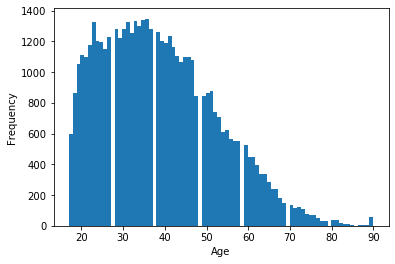

In [131]:
# The sample distribution of ages appears to be slightly right skewed with very slight negative kurtosis. This may need transformed for future modelling.
# Let's visualize this one to confirm the skewness.
x = data_original.age
pl.hist(x, bins=80)
pl.xlabel('Age')
pl.ylabel('Frequency')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hrsperwk,native,label,log_age,age_ZCentered,log_age_ZCentered
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,3.663562,0.025996,0.201990
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,3.912023,0.828308,0.888830
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,3.637586,-0.046942,0.130184
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,3.970292,1.047121,1.049907
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,3.332205,-0.776316,-0.714005


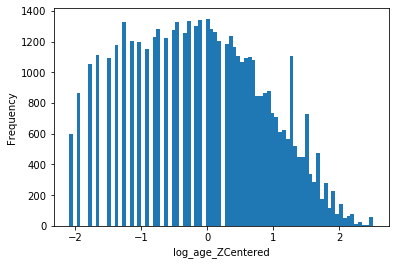

In [132]:
# The values at the end of the right tail are definitely outliers however they're meaningful in our analysis (the elderly are important too). There don't appear to be any obvious
# errors caused by typos (like 500 or 0) 

# I'll create a new feature by taking the log 
# I'll create a new feature by centering with the z score
# I'll create a new feature by taking the log and centering with the z score

logage = np.log(data_original['age'])
data_original['log_age'] = logage

mean = np.mean(data_original['age'])
stdev = np.std(data_original['age'])
data_original['age_ZCentered'] = (data_original['age'] - mean) / stdev

mean = np.mean(logage)
stdev = np.std(logage)
data_original['log_age_ZCentered'] = (logage - mean) / stdev

x = data_original['log_age_ZCentered']
pl.hist(x, bins=80)
pl.xlabel('log_age_ZCentered')
pl.ylabel('Frequency')

# checking for success
data_original.head()

#all good

#######################################################################################################################################################

### **workclass**    /Categorical. Factor levels include: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
                  
Meaning: This feature explains the general category of the economy the individual works within.

In [133]:
feature_name = 'workclass'

# viewing a summary
data_original[[feature_name]].describe()

,workclass
count,48842
unique,9
top,Private
freq,33906


In [134]:
# Roughly 3/4 of our individuals appear to be working in the private sector. Describe returned that there are 9 factor levels in this feature when we know there are actually 
# only 8. so there must be missing values in this feature. Let's check.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')


Number of missing values (?): 2799
Number of null values: workclass    0
dtype: int64


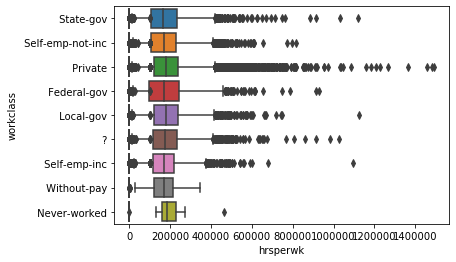

In [135]:
# There are 2799 ? values currently. None of them are Null or NaN values, so that's good. We have a few options here. The first is to impute the mode level (Private). 
# The second is to check if there are any other features here that might explain variation in with workclass, then if so, predict the missing workclass values. The third is 
# leave the ? value in as a placeholder unkown value and predict based on the effect of the level as we would any other feature.

# I'll make some boxplots to see if there's any explainable variation.

sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["workclass"] )
sb.boxplot( x=data_original["fnlwgt"], y=data_original["workclass"] )
sb.boxplot( x=data_original["education-num"], y=data_original["workclass"] )
sb.boxplot( x=data_original["cap-gain"], y=data_original["workclass"] )
sb.boxplot( x=data_original["cap-loss"], y=data_original["workclass"] )
sb.boxplot( x=data_original["hrsperwk"], y=data_original["workclass"] )

In [136]:
# None of these give off the appearance of explainatory variation that I'm looking to test with ANOVA so I'll impute the mode (Private) for the missing values. This can
# always be undone later during the modelling fase should we like to check how well we can predict with an unkown value effect.

# Checking the original counts at each factor level
data_original.groupby(feature_name).count()

# Making the replacement and recalculating the values
data_original[[feature_name]] = data_original[[feature_name]].replace([" ?"], [" Private"])
data_original.groupby(feature_name).count()

# All good.

,age,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,cap-gain,cap-loss,hrsperwk,native,label,log_age,age_ZCentered,log_age_ZCentered
workclass,,,,,,,,,,,,,,,,,
Federal-gov,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432,1432
Local-gov,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136,3136
Never-worked,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Private,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705,36705
Self-emp-inc,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695
Self-emp-not-inc,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862,3862
State-gov,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981,1981
Without-pay,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21


#######################################################################################################################################################

### **fnlwgt**    /Continuous. 

Meaning: The feature "fnlwgt" was added by the dataset authors as a controlled estimate of certain socio-economic effects that take individual state population distributions into account.

In [137]:
feature_name = 'fnlwgt'

# viewing a summary
data_original[[feature_name]].describe()

,fnlwgt
count,4.884200e+04
mean,1.896641e+05
std,1.056040e+05
min,1.228500e+04
25%,1.175505e+05
50%,1.781445e+05
75%,2.376420e+05
max,1.490400e+06


In [138]:
# These are large numbers, any predictive model we apply on this data set would befit from some regularization here in the future. The max is exponetially larger than the mean.
# High values in fnlwgt will need investigated.

# Let's check for missing values.
boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: fnlwgt    0
dtype: int64


In [139]:
# None, the data set authors created this feature so that should have been expected. Thanks authors!

# Checking skewness and kurtosis.
print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: 1.438847687943433
Kurtosis: 6.057105240227166


Text(0, 0.5, 'Frequency')

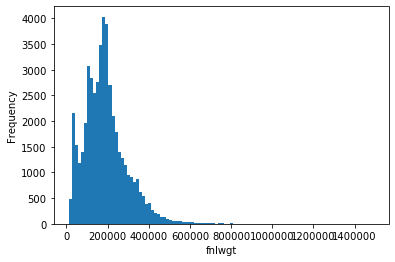

In [140]:
# The fnlwgt column has some strong right skew and high positive kurtosis. It should look like a big spike on the left side of the distribution.

# Let's visualize to confirm.
x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('fnlwgt')
pl.ylabel('Frequency')


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,cap-loss,hrsperwk,native,label,log_age,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,0,40,United-States,<=50K,3.663562,0.025996,0.201990,11.258240,-1.061979,-1.148845
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,0,13,United-States,<=50K,3.912023,0.828308,0.888830,11.330336,-1.007104,-1.034554
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0,40,United-States,<=50K,3.637586,-0.046942,0.130184,12.281393,0.246034,0.473106
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,0,40,United-States,<=50K,3.970292,1.047121,1.049907,12.366153,0.426663,0.607470
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,0,40,Cuba,<=50K,3.332205,-0.776316,-0.714005,12.732011,1.408530,1.187445


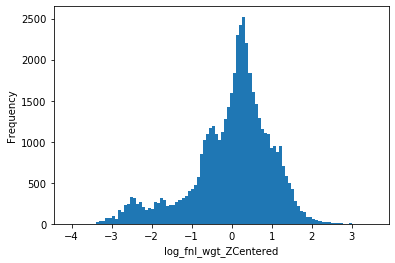

In [141]:
# Yup. This feature would benefit from a log transformation. 

# Creating new features. I'll take the log transform then standardize that using the z-score.
logfnlwgt = np.log(data_original['fnlwgt'])
data_original['log_fnlwgt'] = logfnlwgt

mean = np.mean(data_original['fnlwgt'])
stdev = np.std(data_original['fnlwgt'])
data_original['fnl_wgt_ZCentered'] = (data_original['fnlwgt'] - mean) / stdev

mean = np.mean(logfnlwgt)
stdev = np.std(logfnlwgt)
data_original['log_fnl_wgt_ZCentered'] = (logfnlwgt - mean) / stdev

x = data_original['log_fnl_wgt_ZCentered']
pl.hist(x, bins=100)
pl.xlabel('log_fnl_wgt_ZCentered')
pl.ylabel('Frequency')

# checking for success
data_original.head()

# all good

In [142]:
#Let's view the largest values of the distribution. 
data_original.nlargest(10, ['log_fnl_wgt_ZCentered']) 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,cap-loss,hrsperwk,native,label,log_age,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered
7974,27,Private,1490400,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,0,40,United-States,<=50K,3.295837,-0.849254,-0.814539,14.214555,12.317231,3.537642
14449,25,Private,1484705,Some-college,10,Divorced,Exec-managerial,Unmarried,White,Female,...,0,25,United-States,<=50K,3.218876,-0.995129,-1.027288,14.210727,12.263303,3.531573
18138,39,Private,1455435,Assoc-acdm,12,Separated,Craft-repair,Not-in-family,White,Male,...,0,40,United-States,<=50K,3.663562,0.025996,0.201990,14.190815,11.986132,3.500009
16739,45,Private,1366120,Assoc-voc,11,Divorced,Other-service,Not-in-family,White,Female,...,0,8,United-States,<=50K,3.806662,0.463621,0.597574,14.127485,11.140370,3.399615
15569,29,Private,1268339,HS-grad,9,Married-spouse-absent,Tech-support,Own-child,Black,Male,...,0,40,United-States,<=50K,3.367296,-0.703379,-0.616999,14.053219,10.214439,3.281884
8258,35,Private,1226583,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,...,0,52,United-States,>50K,3.555348,-0.265754,-0.097153,14.019743,9.819034,3.228817
14523,31,Private,1210504,10th,6,Married-civ-spouse,Adm-clerical,Wife,White,Female,...,0,40,United-States,<=50K,3.433987,-0.557504,-0.432639,14.006547,9.666775,3.207899
5369,30,Private,1184622,Some-college,10,Married-civ-spouse,Transport-moving,Husband,Black,Male,...,0,35,United-States,<=50K,3.401197,-0.630441,-0.523283,13.984934,9.421687,3.173637
25075,33,Private,1161363,Some-college,10,Separated,Tech-support,Unmarried,White,Female,...,0,50,Columbia,<=50K,3.496508,-0.411629,-0.259810,13.965105,9.201437,3.142202
29164,42,Local-gov,1125613,HS-grad,9,Divorced,Other-service,Not-in-family,Black,Male,...,0,40,United-States,<=50K,3.737670,0.244808,0.406852,13.933838,8.862905,3.092637


In [143]:
# Regarding the outliers at the tail of fnlwgt, none of these appear to be abnormal. We can't know forsure 
# without knowing how fnlwgt was calulated, yet the consistent increasing of the feature values up to the max appears systematic and not erroneous. I won't do anything
# special about them.

#######################################################################################################################################################

### **Education**    /Categorical. Factor levels include: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
                  
Meaning: How much schooling the individual has completed.

In [144]:
feature_name = 'education'

# viewing a summary
data_original[[feature_name]].describe()

,education
count,48842
unique,16
top,HS-grad
freq,15784


In [145]:
# Seeing the correct number of unique factor levels here so likely no missing values. HS-grad is the most common level
# Let's confirm:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: education    0
dtype: int64


In [146]:
# Yup. Looking good here.

#######################################################################################################################################################

### **education-num**    /continuous. 

Meaning: The number of years of education completed by and individual.

In [147]:
feature_name = 'education-num'

# viewing a summary
data_original[[feature_name]].describe()

,education-num
count,48842.000000
mean,10.078089
std,2.570973
min,1.000000
25%,9.000000
50%,10.000000
75%,12.000000
max,16.000000


In [148]:
# Mean value of ~10. Max and min are prestty evenly spread.
# Checking for missing values:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: education-num    0
dtype: int64


In [149]:
# Let's look at the skewness and kurtosis:

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: -0.3165151356965018
Kurtosis: 0.6255583739336319


Text(0, 0.5, 'Frequency')

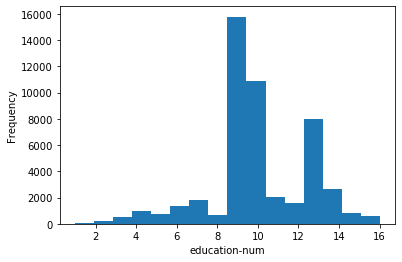

In [150]:
# Slight positive kurtosis, slight left skew. Let's visualize:

x = data_original[feature_name]
pl.hist(x, bins=16)
pl.xlabel('education-num')
pl.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

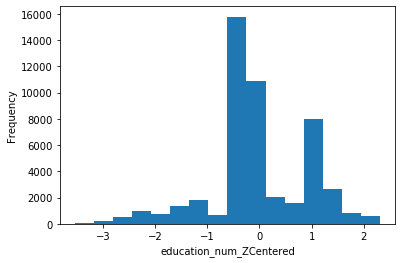

In [151]:
# This distribution appears bimodal. Likely due to the effect of college. This might make the categorical feature (education) more useful to us.

# I'll scale this by transforming it with the Z-score.

mean = np.mean(data_original[feature_name])
stdev = np.std(data_original[feature_name])
education_num_ZCentered = (data_original[feature_name] - mean) / stdev

# Visualizing:
x = education_num_ZCentered
pl.hist(x, bins=16)
pl.xlabel('education_num_ZCentered')
pl.ylabel('Frequency')

In [152]:
# Now to replace the original feature with the transformed version.

data_original['education_num_ZCentered'] = education_num_ZCentered

# Checking:
data_original.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hrsperwk,native,label,log_age,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered,education_num_ZCentered
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,40,United-States,<=50K,3.663562,0.025996,0.201990,11.258240,-1.061979,-1.148845,1.136512
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,13,United-States,<=50K,3.912023,0.828308,0.888830,11.330336,-1.007104,-1.034554,1.136512
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,40,United-States,<=50K,3.637586,-0.046942,0.130184,12.281393,0.246034,0.473106,-0.419335
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,40,United-States,<=50K,3.970292,1.047121,1.049907,12.366153,0.426663,0.607470,-1.197259
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,40,Cuba,<=50K,3.332205,-0.776316,-0.714005,12.732011,1.408530,1.187445,1.136512


#######################################################################################################################################################

### **marital-status**    /Categorical. Factor-levels include: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
                       
Meaning: Whether the individual is married or divorced, etc. Interesting because houses with two income sources will be different than one.

In [153]:
feature_name = 'marital-status'

# viewing a summary
data_original[[feature_name]].describe()

,marital-status
count,48842
unique,7
top,Married-civ-spouse
freq,22379


In [154]:
# There are 7 unique factor levels present in our distribution. So, likely no missing values. We can confirm.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: marital-status    0
dtype: int64


#######################################################################################################################################################

### **occupation**    /Categorical. Factor-levels include: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
                       
Meaning: The field in which the individual works.

In [155]:
feature_name = 'occupation'

# viewing a summary
data_original[[feature_name]].describe()

,occupation
count,48842
unique,15
top,Prof-specialty
freq,6172


In [156]:
# There are only supposed to be 14 factor levels so they're definitely some missing values here.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 2809
Number of null values: occupation    0
dtype: int64


In [157]:
# 2809 missing values. I'll impute the mode value (Prof-specialty)

data_original.groupby(feature_name).count()

# Making the replacement and recalculating the values
data_original[[feature_name]] = data_original[[feature_name]].replace([" ?"], [" Prof-specialty"])
data_original.groupby(feature_name).count()

# Worked fine.

,age,workclass,fnlwgt,education,education-num,marital-status,relationship,race,sex,cap-gain,...,hrsperwk,native,label,log_age,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered,education_num_ZCentered
occupation,,,,,,,,,,,,,,,,,,,,,
Adm-clerical,5611,5611,5611,5611,5611,5611,5611,5611,5611,5611,...,5611,5611,5611,5611,5611,5611,5611,5611,5611,5611
Armed-Forces,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
Craft-repair,6112,6112,6112,6112,6112,6112,6112,6112,6112,6112,...,6112,6112,6112,6112,6112,6112,6112,6112,6112,6112
Exec-managerial,6086,6086,6086,6086,6086,6086,6086,6086,6086,6086,...,6086,6086,6086,6086,6086,6086,6086,6086,6086,6086
Farming-fishing,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490,...,1490,1490,1490,1490,1490,1490,1490,1490,1490,1490
Handlers-cleaners,2072,2072,2072,2072,2072,2072,2072,2072,2072,2072,...,2072,2072,2072,2072,2072,2072,2072,2072,2072,2072
Machine-op-inspct,3022,3022,3022,3022,3022,3022,3022,3022,3022,3022,...,3022,3022,3022,3022,3022,3022,3022,3022,3022,3022
Other-service,4923,4923,4923,4923,4923,4923,4923,4923,4923,4923,...,4923,4923,4923,4923,4923,4923,4923,4923,4923,4923
Priv-house-serv,242,242,242,242,242,242,242,242,242,242,...,242,242,242,242,242,242,242,242,242,242


#######################################################################################################################################################

### **relationship**    /Categorical. Factor Values: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
                     
Meaning: The type of relationship the individual is in.

In [158]:
feature_name = 'relationship'

# viewing a summary
data_original[[feature_name]].describe()

,relationship
count,48842
unique,6
top,Husband
freq,19716


In [159]:
# Seeing 6 unique factor levels as expected. Most common level is Husband.
# Confirming no missing values

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: relationship    0
dtype: int64


In [160]:
# Good.

#######################################################################################################################################################

### **race**    /Categorical. Factor levels include: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
             
Meaning: The race of the individual.

In [161]:
feature_name = 'race'

# viewing a summary
data_original[[feature_name]].describe()

,race
count,48842
unique,5
top,White
freq,41762


In [162]:
# Seeing 5 unique factor levels as expected. Most common level is White.
# Confirming no missing values

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: race    0
dtype: int64


In [163]:
# Good.

#######################################################################################################################################################

### **sex**    /Categorical. Factor levels include: Female, Male. 

Meaning: The sex of the individual.

In [164]:
feature_name = 'sex'

# viewing a summary
data_original[[feature_name]].describe()

,sex
count,48842
unique,2
top,Male
freq,32650


In [165]:
# Seeing 2 unique factor levels as expected. Most common level is Male.
# Confirming no missing values

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: sex    0
dtype: int64


In [166]:
# Good.

#######################################################################################################################################################

### **cap-gain**    /Continuous. 

Meaning: Dollars gained by the individual's investments during the year.

In [167]:
feature_name = 'cap-gain'

# viewing a summary
data_original[[feature_name]].describe()

,cap-gain
count,48842.000000
mean,1079.067626
std,7452.019058
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,99999.000000


In [168]:
# The summary here tells us the mean gain is about a thousand dollars. The distribution appears to be dramatically right skewed and is likely mostly (0) values.
# Let's comfirm by checking skew and kurtosis.

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: 11.894293693350868
Kurtosis: 152.6773425724958


In [169]:
# Yeah . . . we'll be transforming this one. First, Let's check for missing values.

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: cap-gain    0
dtype: int64


Text(0, 0.5, 'Frequency')

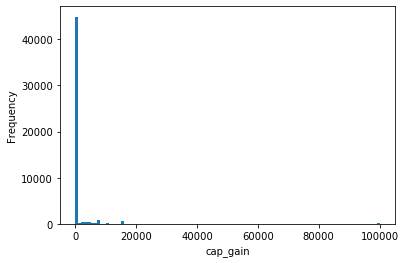

In [170]:
# None. That's helpful. Time to visualize this one.

x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('cap_gain')
pl.ylabel('Frequency')

In [171]:
# Before I transform this, I want to investigate the outlier here that's near 100K.

data_original.nlargest(10, [feature_name]) 

# I've actually viewed the top 60 largest values here but I set the code back to outputting the top 10 to keep this report cleaner.
# The trend shown in the top 10 is the same as the top 60, all are labeled > 50k. 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hrsperwk,native,label,log_age,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered,education_num_ZCentered
1246,54,Self-emp-inc,166459,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,60,United-States,>50K,3.988984,1.120058,1.101579,12.022504,-0.219739,0.062703,1.914436
1368,52,Private,152234,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,...,40,Japan,>50K,3.951244,0.974183,0.997251,11.933174,-0.354442,-0.078908,-0.419335
1482,53,Self-emp-inc,263925,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,...,40,United-States,>50K,3.970292,1.047121,1.049907,12.483420,0.703208,0.793368,-0.419335
1528,52,Private,118025,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,50,United-States,>50K,3.951244,0.974183,0.997251,11.678652,-0.678382,-0.482388,1.136512
1616,46,Private,370119,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,60,United-States,>50K,3.828641,0.536558,0.658332,12.821580,1.708805,1.329434,1.914436
1682,43,Private,176270,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,60,United-States,>50K,3.761200,0.317746,0.471899,12.079772,-0.126835,0.153486,1.136512
1765,49,Private,159816,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,...,20,United-States,>50K,3.891820,0.755371,0.832982,11.981778,-0.282645,-0.001858,1.136512
1771,50,Private,171338,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,50,United-States,>50K,3.912023,0.828308,0.888830,12.051393,-0.173538,0.108499,-0.030373
1826,22,Self-emp-not-inc,202920,HS-grad,9,Never-married,Prof-specialty,Unmarried,White,Female,...,40,Dominican-Republic,>50K,3.091042,-1.213941,-1.380667,12.220567,0.125526,0.376681,-0.419335
2103,43,Self-emp-inc,172826,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,...,55,United-States,>50K,3.761200,0.317746,0.471899,12.060041,-0.159448,0.122207,-0.030373


In [172]:
# I think I want to create a new feature here. A simple binary feature specifying whether the individual made > 50K in capital gains alone.

data_original['cap-gains50k'] = data_original.apply(lambda x: True if x[feature_name] > 50000 else False, axis=1).astype('category')

# Checking that it worked:
data_original.nlargest(10, [feature_name]) 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,native,label,log_age,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered,education_num_ZCentered,cap-gains50k
1246,54,Self-emp-inc,166459,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,United-States,>50K,3.988984,1.120058,1.101579,12.022504,-0.219739,0.062703,1.914436,True
1368,52,Private,152234,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,...,Japan,>50K,3.951244,0.974183,0.997251,11.933174,-0.354442,-0.078908,-0.419335,True
1482,53,Self-emp-inc,263925,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,...,United-States,>50K,3.970292,1.047121,1.049907,12.483420,0.703208,0.793368,-0.419335,True
1528,52,Private,118025,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,United-States,>50K,3.951244,0.974183,0.997251,11.678652,-0.678382,-0.482388,1.136512,True
1616,46,Private,370119,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,United-States,>50K,3.828641,0.536558,0.658332,12.821580,1.708805,1.329434,1.914436,True
1682,43,Private,176270,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,United-States,>50K,3.761200,0.317746,0.471899,12.079772,-0.126835,0.153486,1.136512,True
1765,49,Private,159816,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,...,United-States,>50K,3.891820,0.755371,0.832982,11.981778,-0.282645,-0.001858,1.136512,True
1771,50,Private,171338,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,United-States,>50K,3.912023,0.828308,0.888830,12.051393,-0.173538,0.108499,-0.030373,True
1826,22,Self-emp-not-inc,202920,HS-grad,9,Never-married,Prof-specialty,Unmarried,White,Female,...,Dominican-Republic,>50K,3.091042,-1.213941,-1.380667,12.220567,0.125526,0.376681,-0.419335,True
2103,43,Self-emp-inc,172826,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,...,United-States,>50K,3.761200,0.317746,0.471899,12.060041,-0.159448,0.122207,-0.030373,True


Text(0, 0.5, 'Frequency')

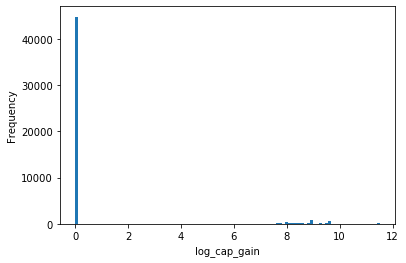

In [173]:
# That should be a really significant factor in whatever model we might use to predict our label.
# Now I'll transform the original cap-gain feature. Taking a log of 0 will produce NaNs so I'll transform the feature to log(cap-gains + 1) and then I'll scale It with the z-score.

log_cap_gain = np.log(data_original[feature_name] + 1)
data_original['log_cap_gain'] = log_cap_gain

# Visualizing:
x = log_cap_gain
pl.hist(x, bins=100)
pl.xlabel('log_cap_gain')
pl.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

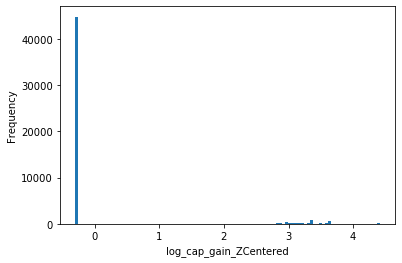

In [174]:
# Now scaling by Z-score:

mean = np.mean(data_original[feature_name])
stdev = np.std(data_original[feature_name])
data_original['cap_gain_ZCentered'] = (data_original[feature_name] - mean) / stdev

mean = np.mean(log_cap_gain)
stdev = np.std(log_cap_gain)
data_original['log_cap_gain_ZCentered'] = (log_cap_gain - mean) / stdev

# Visualizing:
x = data_original['log_cap_gain_ZCentered']
pl.hist(x, bins=100)
pl.xlabel('log_cap_gain_ZCentered')
pl.ylabel('Frequency')

In [175]:
# Checking:
data_original.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered,education_num_ZCentered,cap-gains50k,log_cap_gain,cap_gain_ZCentered,log_cap_gain_ZCentered
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,0.025996,0.201990,11.258240,-1.061979,-1.148845,1.136512,False,7.684784,0.146932,2.844559
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,0.828308,0.888830,11.330336,-1.007104,-1.034554,1.136512,False,0.000000,-0.144804,-0.297918
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,-0.046942,0.130184,12.281393,0.246034,0.473106,-0.419335,False,0.000000,-0.144804,-0.297918
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,1.047121,1.049907,12.366153,0.426663,0.607470,-1.197259,False,0.000000,-0.144804,-0.297918
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,-0.776316,-0.714005,12.732011,1.408530,1.187445,1.136512,False,0.000000,-0.144804,-0.297918


In [176]:
# Good.

#######################################################################################################################################################

### **capital-loss**    /Continuous. 

Meaning: Dollars lost by the individual's investments during the year.

In [177]:
feature_name = 'cap-loss'

# viewing a summary
data_original[[feature_name]].describe()

,cap-loss
count,48842.000000
mean,87.502314
std,403.004552
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4356.000000


In [178]:
# This distribution appears that it'll be similar to cap-gain. However, the max loss is far less than 50K so I don't think I'll be making a new feature representing this one.
# Let's check for missing values:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 0
Number of null values: cap-loss    0
dtype: int64


In [179]:
# Good. Now skewness and kurtosis:

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

Skewness: 4.569668511893423
Kurtosis: 20.012174283988244


Text(0, 0.5, 'Frequency')

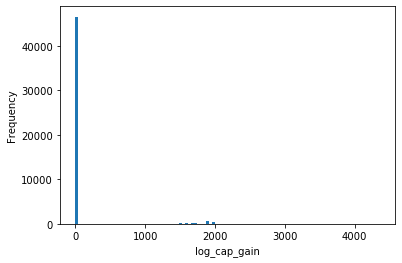

In [180]:
# Yeah pretty bad. Time to visualize:

x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('log_cap_gain')
pl.ylabel('Frequency')

In [181]:
# I know the max value, it's definitly an outlier. Let's invetigate for others.

data_original.nlargest(10, [feature_name]) 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,age_ZCentered,log_age_ZCentered,log_fnlwgt,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered,education_num_ZCentered,cap-gains50k,log_cap_gain,cap_gain_ZCentered,log_cap_gain_ZCentered
8963,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,...,3.745808,2.513692,11.252249,-1.066364,-1.158342,-0.419335,False,0.0,-0.144804,-0.297918
14756,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,3.162308,2.256355,11.797126,-0.537808,-0.294576,-0.419335,False,0.0,-0.144804,-0.297918
30781,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,...,1.995308,1.656308,12.133830,-0.034120,0.239181,-0.030373,False,0.0,-0.144804,-0.297918
20416,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,1.120058,1.101579,11.851959,-0.466892,-0.207654,-2.364144,False,0.0,-0.144804,-0.297918
23802,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,...,0.171871,0.340238,12.486213,0.710197,0.797794,-0.030373,False,0.0,-0.144804,-0.297918
11902,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,...,-0.338691,-0.177285,12.287026,0.257567,0.482034,-0.419335,False,0.0,-0.144804,-0.297918
15942,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,...,-0.046942,0.130184,11.922389,-0.369906,-0.096004,-1.586221,False,0.0,-0.144804,-0.297918
9303,52,Private,106176,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Male,...,0.974183,0.997251,11.572853,-0.790585,-0.650104,1.136512,False,0.0,-0.144804,-0.297918
12770,31,Private,293594,HS-grad,9,Never-married,Adm-clerical,Unmarried,White,Female,...,-0.557504,-0.432639,12.589953,0.984157,0.962249,-0.419335,False,0.0,-0.144804,-0.297918
12600,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,...,2.578808,1.972581,11.392316,-0.956660,-0.936301,2.303397,False,0.0,-0.144804,-0.297918


Text(0, 0.5, 'Frequency')

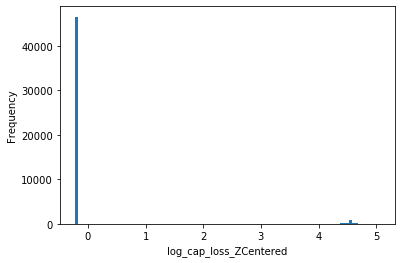

In [182]:
# These all look proper. I'll apply the same transformation to this as I did on cap-gain to keep it consistently scaled with the rest of our features.

log_cap_loss = np.log(data_original[feature_name] + 1)
data_original['log_cap_loss'] = log_cap_loss

mean = np.mean(data_original[feature_name])
stdev = np.std(data_original[feature_name])
cap_loss_ZCentered = (data_original[feature_name] - mean) / stdev

mean = np.mean(log_cap_loss)
stdev = np.std(log_cap_loss)
log_cap_loss_ZCentered = (log_cap_loss - mean) / stdev

# Visualizing:
x = log_cap_loss_ZCentered
pl.hist(x, bins=100)
pl.xlabel('log_cap_loss_ZCentered')
pl.ylabel('Frequency')

In [183]:
# Now to replace the original feature with the transformed version.

data_original['cap_loss_ZCentered'] = cap_loss_ZCentered
data_original['log_cap_loss_ZCentered'] = log_cap_loss_ZCentered

# Checking:
data_original.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,fnl_wgt_ZCentered,log_fnl_wgt_ZCentered,education_num_ZCentered,cap-gains50k,log_cap_gain,cap_gain_ZCentered,log_cap_gain_ZCentered,log_cap_loss,cap_loss_ZCentered,log_cap_loss_ZCentered
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,-1.061979,-1.148845,1.136512,False,7.684784,0.146932,2.844559,0.0,-0.217127,-0.221264
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,-1.007104,-1.034554,1.136512,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0.246034,0.473106,-0.419335,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,0.426663,0.607470,-1.197259,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,1.408530,1.187445,1.136512,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264


In [184]:
# Good.

#######################################################################################################################################################

### **hrsperwk**    /Continuous. 

Meaning: The number of hours an individual works per week.

In [185]:
feature_name = 'hrsperwk'

# viewing a summary
data_original[[feature_name]].describe()

,hrsperwk
count,48842.000000
mean,40.422382
std,12.391444
min,1.000000
25%,40.000000
50%,40.000000
75%,45.000000
max,99.000000


In [186]:
# Mean is about 40 hours, as expected. The first and third quartile are pretty tight to the mean so we'll likely see high kurtosis here. Probably some minor right skew too.
# I'll check skewness and kurtosis, as well as for missing values:

print(f'Skewness: {skew(data_original[feature_name])}')
print(f'Kurtosis: {kurtosis(data_original[feature_name])}')

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Skewness: 0.2387423248342843
Kurtosis: 2.950634153321035
Number of missing values (?): 0
Number of null values: hrsperwk    0
dtype: int64


Text(0, 0.5, 'Frequency')

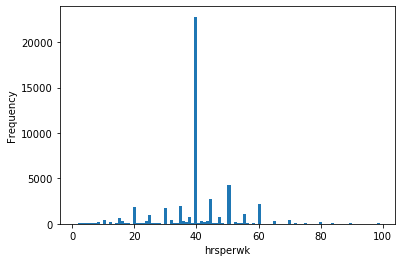

In [187]:
# Yup. Glad there aren't missing values.
# Let's visualize:

x = data_original[feature_name]
pl.hist(x, bins=100)
pl.xlabel('hrsperwk')
pl.ylabel('Frequency')

In [188]:
# I'll just Z-center this one to scale it properly. The skewness here isn't that extreme.

mean = np.mean(data_original[feature_name])
stdev = np.std(data_original[feature_name])
hrs_per_wk_ZCentered = (data_original[feature_name] - mean) / stdev

# Now to add the transformed version.

data_original['hrs_per_wk_ZCentered'] = hrs_per_wk_ZCentered

# Checking:
data_original.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,log_fnl_wgt_ZCentered,education_num_ZCentered,cap-gains50k,log_cap_gain,cap_gain_ZCentered,log_cap_gain_ZCentered,log_cap_loss,cap_loss_ZCentered,log_cap_loss_ZCentered,hrs_per_wk_ZCentered
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,-1.148845,1.136512,False,7.684784,0.146932,2.844559,0.0,-0.217127,-0.221264,-0.034087
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,-1.034554,1.136512,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-2.213032
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0.473106,-0.419335,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-0.034087
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,0.607470,-1.197259,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-0.034087
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,1.187445,1.136512,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-0.034087


#######################################################################################################################################################

### **native**    /Categorical. Factor Levels include: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Meaning: The country the individual was born in.

In [189]:
feature_name = 'native'

# viewing a summary
data_original[[feature_name]].describe()

,native
count,48842
unique,42
top,United-States
freq,43832


In [190]:
# Our summary tells us there are 42 unique factor levels here. However, there are only 41 listed in the description, so we have missing values. Most common value is United-states
# Confirming:

boolseries = data_original.apply(lambda x: True if x[feature_name] == ' ?' else False, axis=1)
print(f'Number of missing values (?): {len(boolseries[boolseries == True].index)}')
print(f'Number of null values: {data_original[[feature_name]].isnull().sum()}')

Number of missing values (?): 857
Number of null values: native    0
dtype: int64


In [191]:
# I'll impute the mode (United-States) for the missing values.

data_original.groupby(feature_name).count()

# Making the replacement and recalculating the values
data_original[[feature_name]] = data_original[[feature_name]].replace([" ?"], [" United-States"])
data_original.groupby(feature_name).count()

# Worked fine.

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,log_fnl_wgt_ZCentered,education_num_ZCentered,cap-gains50k,log_cap_gain,cap_gain_ZCentered,log_cap_gain_ZCentered,log_cap_loss,cap_loss_ZCentered,log_cap_loss_ZCentered,hrs_per_wk_ZCentered
native,,,,,,,,,,,,,,,,,,,,,
Cambodia,28,28,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28
Canada,182,182,182,182,182,182,182,182,182,182,...,182,182,182,182,182,182,182,182,182,182
China,122,122,122,122,122,122,122,122,122,122,...,122,122,122,122,122,122,122,122,122,122
Columbia,85,85,85,85,85,85,85,85,85,85,...,85,85,85,85,85,85,85,85,85,85
Cuba,138,138,138,138,138,138,138,138,138,138,...,138,138,138,138,138,138,138,138,138,138
Dominican-Republic,103,103,103,103,103,103,103,103,103,103,...,103,103,103,103,103,103,103,103,103,103
Ecuador,45,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,45
El-Salvador,155,155,155,155,155,155,155,155,155,155,...,155,155,155,155,155,155,155,155,155,155
England,127,127,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127


#######################################################################################################################################################

### **Checking for numeric feature correlation**

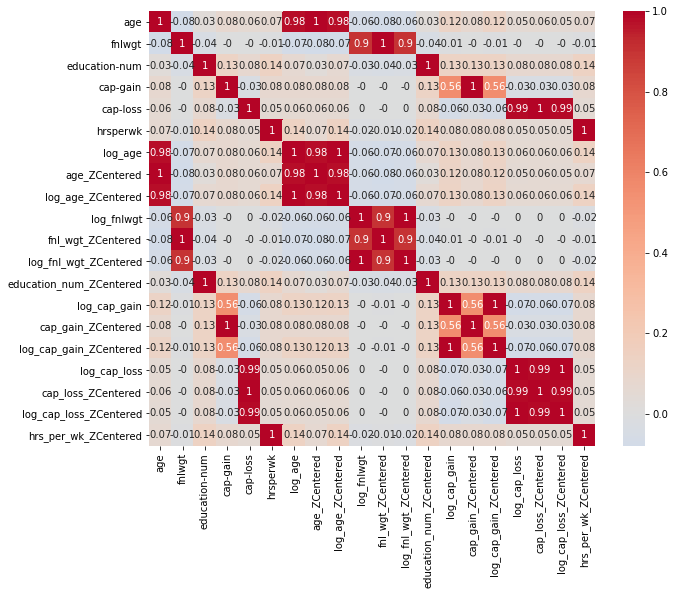

In [192]:
# Checking correlation between all numeric features.

correlation_matrix = data_original.corr().round(2)
pl.figure(figsize=(10,8))
sb.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')

In [193]:
# Our numeric features have very weak correlation to eachother, despite the strong correlations between features and their transformed features that I created. 
# This is good for us if we're looking to predict our label because it means we won't have to worry about the preoblem of multicollinearity among them. 

#######################################################################################################################################################

### **Investigating explainable variation between non-label categorical features**

Features to look at here [workclass, education, marital-status, occupation, relationship, race, sex, cap-gains50k]

Pairs of categorical variables don't have a pearson correlation coefficient.

To explore whether one categorical group effects the distribution of another, I'll be making interaction plots. The plots will consist of lines marking the change in
frequency from one categorical factor level to another. There will be a set of lines per factor level of the second categorical varaible.
Generally when the lines between the factor levels controlling the hue are approximatly paralell this means that the second variable is not really effecting the distribution 
of the first. Otherwise, there may be an interesting effect. In such cases I'll try to explain the interaction or raise questions regarding it.

I'll be skipping interactions with the feature (native) because of the high volume of factor levels. This type of plot will just be confusing with too many levels.

I'll also omit any plots that appear to exhibit little interaction for the sake of brevity.

Text(0.5, 0.98, 'Interaction of education ~ workclass')

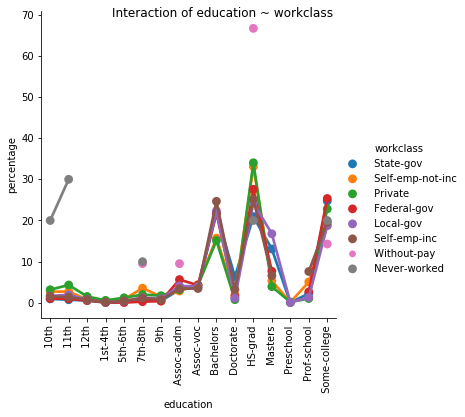

In [194]:
# Each graph will be created with the same code, I'll just switch the names of the variables hue_lab and x_lab
hue_lab = 'workclass'
x_lab = 'education'

# Grouping by the hue_group, then counting by the x_lab group
hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)

# Creating the percentage vector to measure the frequency of each type
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]

# Creating and plotting the new dataframe 
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

The interaction between education and workclass shows a higher percentage of 'HS-grad' individuals in the occupation 'Without-pay' than all the other 'HS-grad' individuals.
There also appear to be more individuals than average who have completed HS or less that are 'Without-pay' or 'Never-worked' than other education groups.

Text(0.5, 0.98, 'Interaction of occupation ~ workclass')

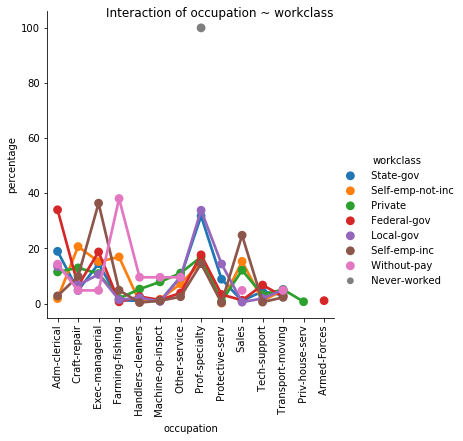

In [195]:
hue_lab = 'workclass'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

There is a lot of variation here within these groups. This may be explained by some occupations being available at different frequencies within different economic sectors. One of which, that is rather extreme, is the armed forces only being a part of the federal government.

Text(0.5, 0.98, 'Interaction of workclass ~ cap-gains50k')

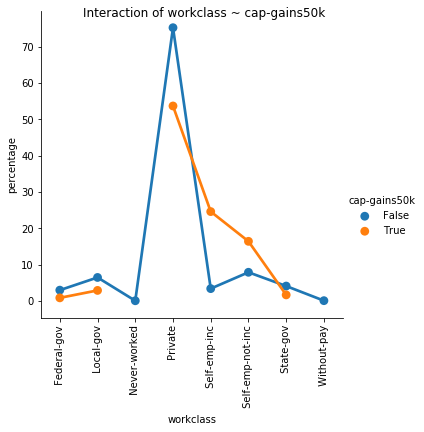

In [196]:
hue_lab = 'cap-gains50k'
x_lab = 'workclass'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here's something interesting, some variation in frequency occuring in the rates of 'cap-gains50k' based on economic sector. Seeing greater frequency of 'cap-gains50k' for individuals that are self employed. This could result from these individuals making less consistent pay than the other factor levels of workclass, thus taking more risk in equities. Or it could also be the result of these individuals making more money than others, due to having a greater share of profit. Higher principle risked on average provides higher return in markets.

Text(0.5, 0.98, 'Interaction of education ~ cap-gains50k')

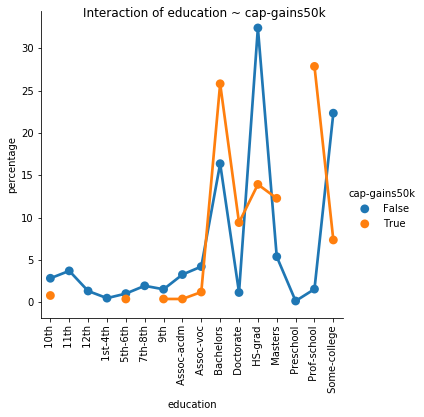

In [197]:
hue_lab = 'cap-gains50k'
x_lab = 'education'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

There's a lot of variation here. In advanced degrees such as prof-school, bachelors, masters, and doctorate individuals have a higher frequency of cap-gains50k being True than False. All other education levels are the opposite. This could be because these degree holders have a hgiher access to capital than the others, due to having better job oppotunities. 

Text(0.5, 0.98, 'Interaction of occupation ~ marital-status')

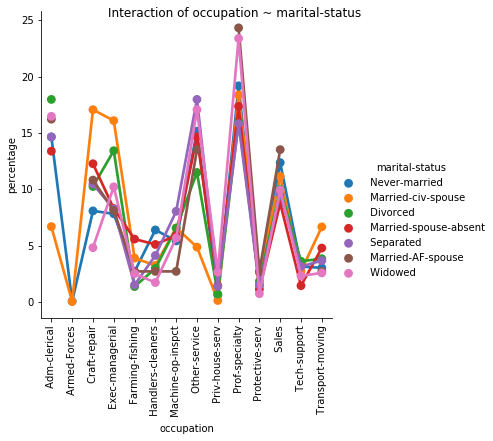

In [198]:
hue_lab = 'marital-status'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This graph is somewhat interesting. Occupations on the right side of the x-axis appear very paralell, where occupations on the left side of the x-axis appear much more mixed. I don't really have any idea why this is occurring.

Text(0.5, 0.98, 'Interaction of marital-status ~ relationship')

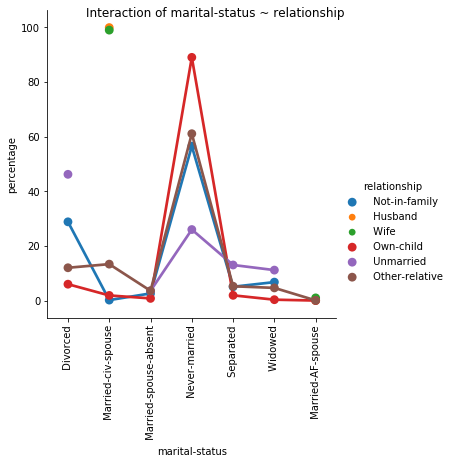

In [199]:
hue_lab = 'relationship'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction isn't all that interesting. I only left it in because of one small detail. The levels of relationship 'Husband' and 'wife' are almost perfectly matched to the factor level 'Married-civ-spouse' in marital-status. These levels essentially describe the same thing and we may want to exclude one the two features from our final model.

Text(0.5, 0.98, 'Interaction of marital-status ~ sex')

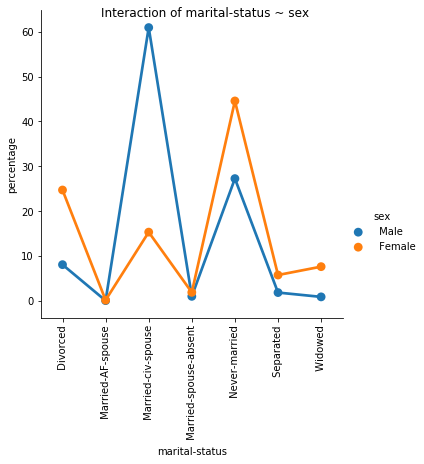

In [200]:
hue_lab = 'sex'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here, our data seems to imply that American men are much more likely to be married than american women. Also, women have a higher percentage of diverce than men. Perhaps the two are connected? Perhaps not? Women are also more liekly to have never been married which may also contribute.

Text(0.5, 0.98, 'Interaction of marital-status ~ cap-gains50k')

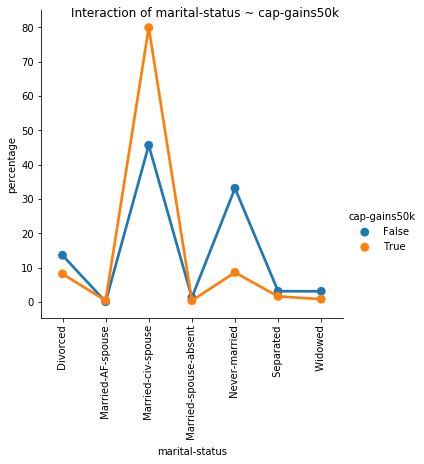

In [201]:
hue_lab = 'cap-gains50k'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction exhibits something a lot of people might expect. Married individuals have a significantly hgiher percentage of cap-gains50k being True than False. Most likely due to two people being able to contribute more capital than one. Also, individuals never-married have significantly lower percentage of cap-gains50k being True than False. For the same reason as previous.

Text(0.5, 0.98, 'Interaction of occupation ~ relationship')

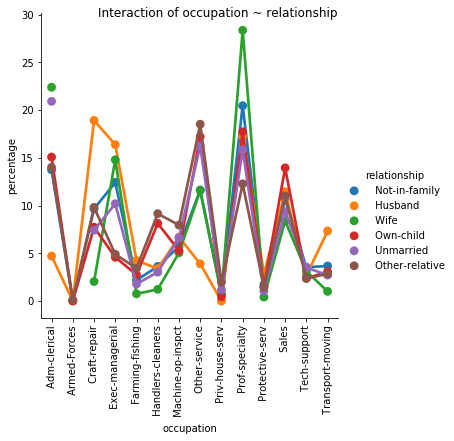

In [202]:
hue_lab = 'relationship'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction shows a lot of the same variation that we saw in the occupation ~ marital-status interation. I'm beleiving more and more that marital-status and relationship are a bit redundant.

Text(0.5, 0.98, 'Interaction of occupation ~ sex')

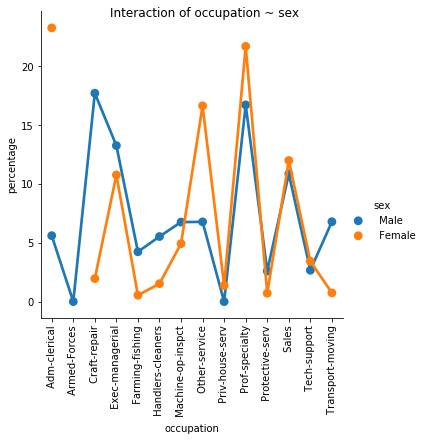

In [203]:
hue_lab = 'sex'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interactions displays the idea that men and women often tend to work in different fields. Especially so in the 'adm-clerical' and 'craft-repair' factor levels. The court is still out on whether this is due to socially constructed entry barriers or that men and women tend to prefer focusing on different thing on average.

Text(0.5, 0.98, 'Interaction of occupation ~ cap-gains50k')

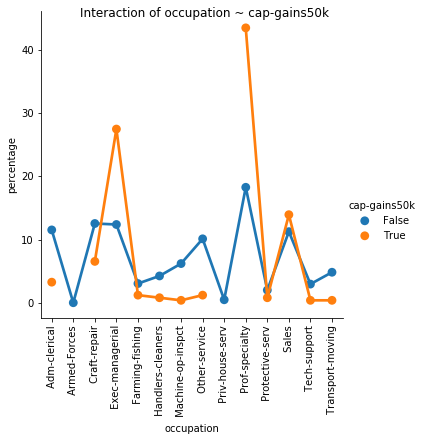

In [204]:
hue_lab = 'cap-gains50k'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here we see that occupation likely has a lot of influence over whether a person makes capital gains greater than 50k in a year. Occupations with the largest disparity between cap-gains50k being True or False are 'Exec-managerial' and 'Prof-specialty'.

Text(0.5, 0.98, 'Interaction of relationship ~ race')

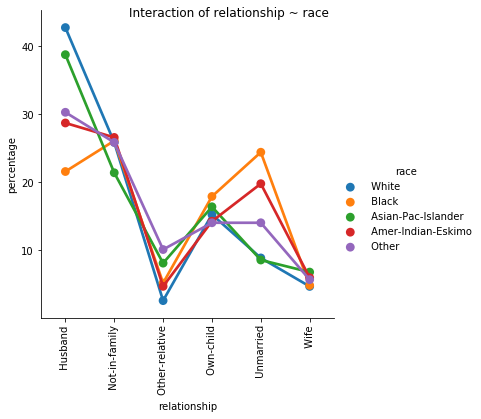

In [205]:
hue_lab = 'race'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Something interesting is definitly happening here. Race appears to effect whether an individual is a husband or Unmarried. The 'wife' designation doesn't show this effect much. All of the wife observations are very close to eachother racially. Yet, 'husband' and 'unmarried' have wider variation and an almost preserved ordering, suggesting a lack of 'black' 'husband' individuals may influence a gain in 'black' 'unmarried' individuals.

Text(0.5, 0.98, 'Interaction of relationship ~ sex')

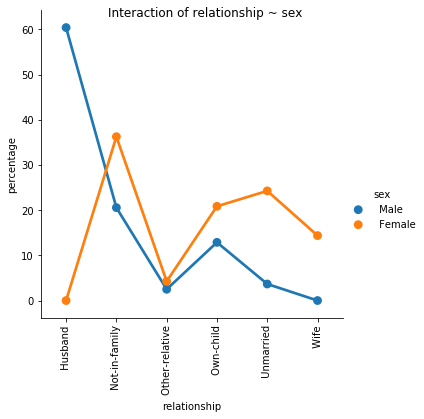

In [206]:
hue_lab = 'sex'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Disregard the disparities here in the 'Husband' and 'wife' relationship designations, these are dependent on sex. The most interesting effect here is that women appear more likely to be an 'only child' or 'unmarried'.

Text(0.5, 0.98, 'Interaction of relationship ~ cap-gains50k')

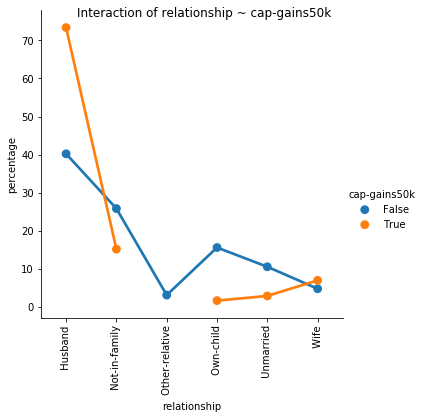

In [207]:
hue_lab = 'cap-gains50k'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Here we see that 'husband' and 'wife' individuals are more likely to have capital gains greater than 50k. Likely, a repeat of the effect we saw earlier that I attributed to married individuals having reater access to capital on average.

Text(0.5, 0.98, 'Interaction of sex ~ cap-gains50k')

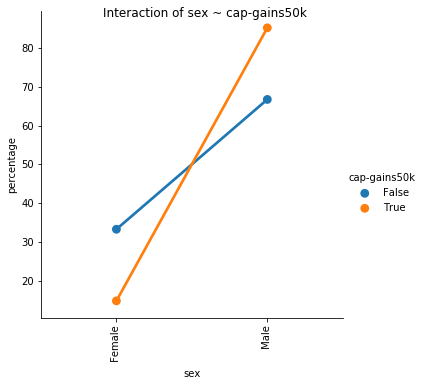

In [208]:
hue_lab = 'cap-gains50k'
x_lab = 'sex'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Why does it appear that men are more likely to have capital gains greater than 50k than women? Are men more aggressive with investments on average? Is it due to men being more likely to be married? Other socio-economic factors?

#######################################################################################################################################################

### **Investigating explainable variation between non-label categorical features and numerical features**

Features to look at here: Continuous[log_age_ZCentered, log_fnl_wgt_ZCentered, education_num_ZCentered, log_cap_gain_ZCentered, log_cap_loss_ZCentered, hrs_per_wk_ZCentered] ~ Categorical[workclass, education, marital-status, occupation, relationship, race, sex, cap-gains50k]

I'll be skipping interactions with the feature (native) because of the high volume of factor levels. Plots will just be confusing with too many levels.

There will be 48 total pairs here to represent with plots so, again, I'll also omit any plots that appear to exhibit little interaction for the sake of brevity.

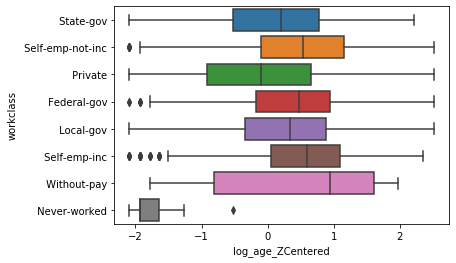

In [209]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["workclass"] )

Here we see younger than average individuals mostly make up the never-worked factor level.

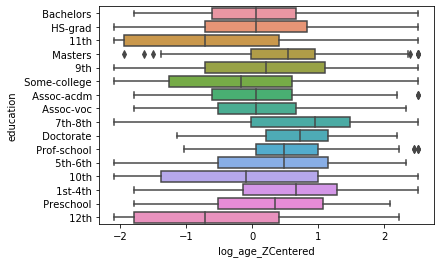

In [210]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["education"] )

Age effects the degree of education an individual has completed. Somewhat a given, but worth noting.

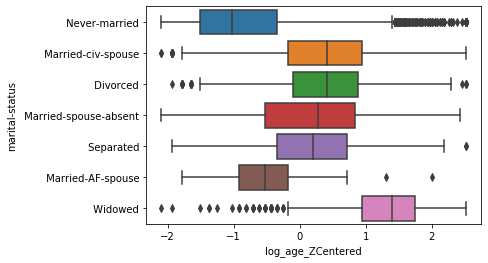

In [211]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["marital-status"] )

Age also effects marital-status. We see younger individuals making up the majority of 'never-married' individuals. We see older individuals making up the mojority of the 'Widowed' factor level.

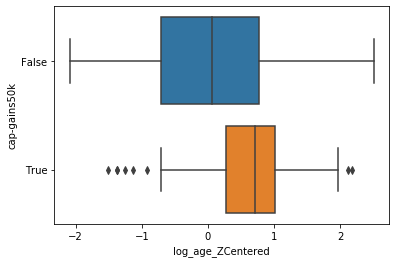

In [212]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["cap-gains50k"] )

The average age on individuals making less than 50k in capital gains is lower than the average age of those making more than 50k in capital gains. The variance of the less than 50k sample is also much wider than the other sample. This makes sense because older individuals have more access to capital and can achieve higher dollar value gains with the same percentage increase in portfolio value.

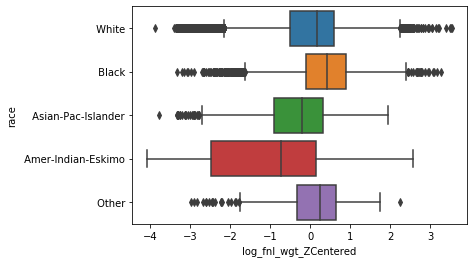

In [213]:
sb.boxplot( x=data_original["log_fnl_wgt_ZCentered"], y=data_original["race"] )

Here we can get a bit of a clue into how racial descriminators effect the value of the final weight feature. American-Indian-Exkimos have a slightly lower average than the other racial groups, but a much lower first quartile than the other racial groups. I still don't know how the authors calculated this statistic so I don't know why this is.

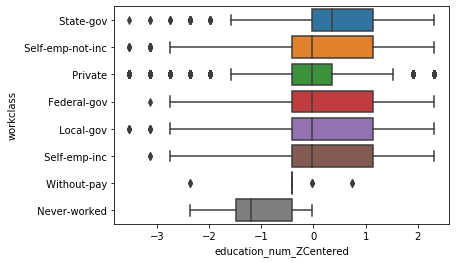

In [214]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["workclass"] )

Mostly less educated individuals appear to make up the 'never-worked' factor level. As we have already attributed younger individuals to the never worked category and to the lower education category, we're likely seeing the same effect here.

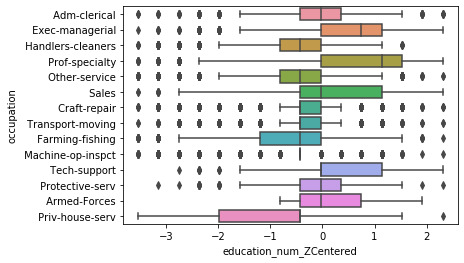

In [215]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["occupation"] )

Years of education completed has a noticable effect on the variation of the 'occupation' feature. Some jobs have higher barriers to entry than others.

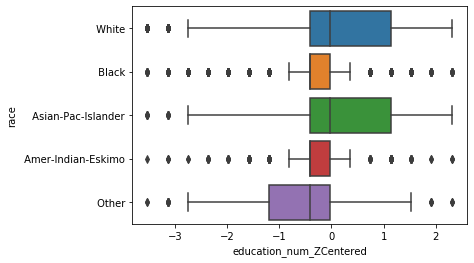

In [216]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["race"] )

The distribution of education years completed appears to change noticably when factored by race. All of the education distributions have similar a mean (likely around graduating from HS) but the thrid quartiles for whites and asians are higher than the remaining races. The other category has a lower first quartile than the remaining distributions. There are outliers in all categories. This effecty is likely due to some socio-economic factors within these communities.

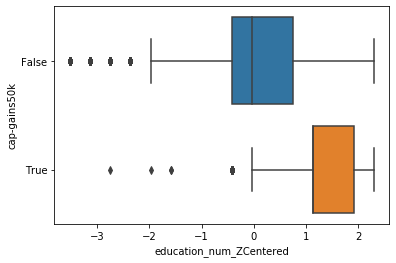

In [217]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["cap-gains50k"] )

Here we see that more educated individuals are much more likely than less educated individuals to achieve greater than 50k in capital gains. Probably due to more educated individuals on average being more specialized and paid more.

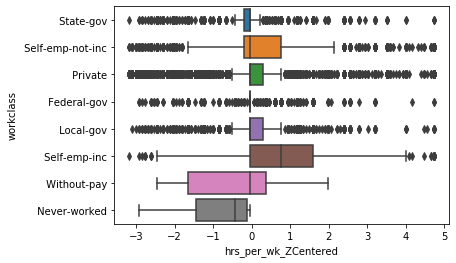

In [218]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["workclass"] )

Here we see a bit of variation between the hours worked per week within different economic sectors. Self employed individuals work more than average and 'without-pay' + 'Never-worked' individuals work much less than average. The remaining groups have similar distributions with many outliers. 

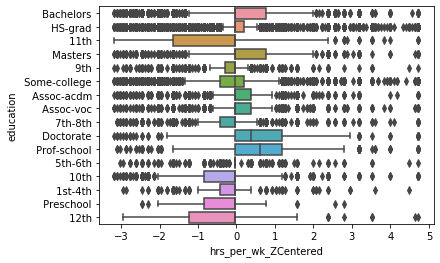

In [219]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["education"] )

College educated individuals and Prof-school individuals appear to work more hours than the average when compared to all other groups. Is this because these groups are on average tackling more complex problems? Is this because these groups are in positions requiring more responsibility, and thus, more time?

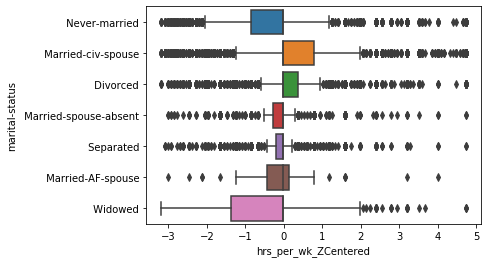

In [220]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["marital-status"] )

Hours worked per week also avaries noticable based on the marital-status of an individual. While all of these factor levels show a similar mean, the first and third quartiles are where we see the effect. Widowed individuals work less than the mean of all groups, likely due to being older on average and perhaps retired. Never married individuals also work less than the shared mean. (perhaps this contributes to why they were never married. Married individuals work slightly more hours than divorced inidividuals for unkown reasons.

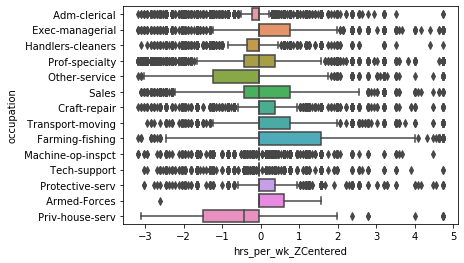

In [221]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["occupation"] )

Here we see how some occupations simply require more time than others, especially farming for example. We all know the common trope of the farmer waking up at the crack of dawn to manage the fields. Is this what the data is showing us?

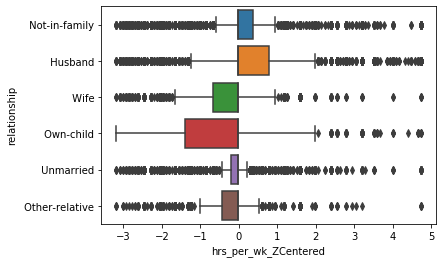

In [222]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["relationship"] )

The most interesting variation between these 'relationship' groups is that husband work on average more hours per week than wives. Is this due to the effect of child rearing? The 'own-child' factor level shows lower hours worked per week than the everage of the rest of the groups. Is this because most of these individuals are younger?

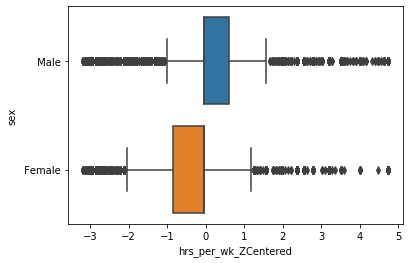

In [223]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["sex"] )

Again, we're seeing that men on average work more hours than women. Again, is this because of the effect of child rearing on the average?

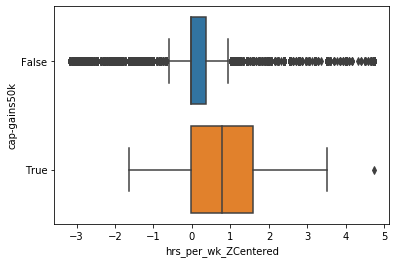

In [224]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["cap-gains50k"] )

Those who work more hours per week appear more likely to achieve grater than 50k of capital gains. Is this because longer hours worked achieves higher pay and more access to capital?

#######################################################################################################################################################

### **Investigating explainable variation between the label and predictor features**

Here, we'll be investigating the relationships between the label and [log_age_ZCentered, log_fnl_wgt_ZCentered, education_num_ZCentered, log_cap_gain_ZCentered, log_cap_loss_ZCentered, hrs_per_wk_ZCentered, workclass, education, marital-status, occupation, relationship, race, sex, cap-gains50k]

I'll be using a combination of the same plots from the last two sections.

I won't omit any plot from this section because there are only 14 of them.

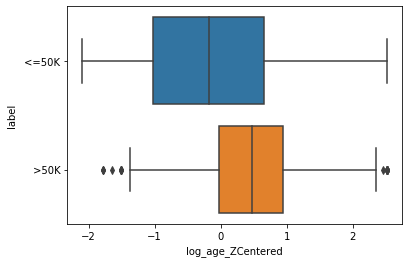

In [225]:
sb.boxplot( x=data_original["log_age_ZCentered"], y=data_original["label"] )

It appears older individuals making > 50k are on average older than the average individual in the sample. Just as we've seen with the cap-gains50k distribution. This is likely due to older individuals being in more senior positions that pay more.

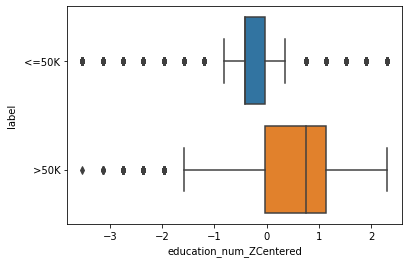

In [226]:
sb.boxplot( x=data_original["education_num_ZCentered"], y=data_original["label"] )

Individuals making > 50k have higher than average years of education completed. The mean of the <= 50k group appears almost and entire standard deviation lower and the variances of the two groups appear significantly different.

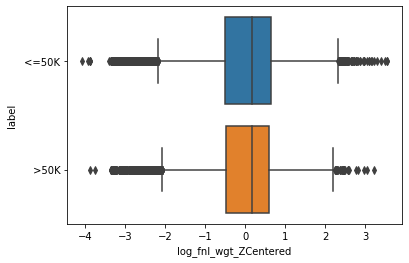

In [227]:
sb.boxplot( x=data_original["log_fnl_wgt_ZCentered"], y=data_original["label"] )

The distributions of the two final weight groups here are very similar. It's likely I wouldn't use this in a predictive model given that thte label was our target. 

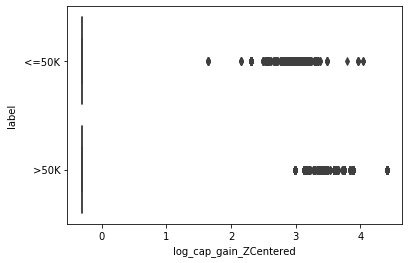

In [228]:
sb.boxplot( x=data_original["log_cap_gain_ZCentered"], y=data_original["label"] )

The average, first & third quartiles, and tails of the two capital gains groups here are all basically 0. This is why I made a categorical feature off of this numeric feature. The distribution of the > 50k outlier appears more concentrated higher than the <= 50k outliers. 

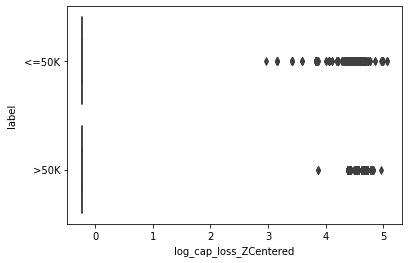

In [229]:
sb.boxplot( x=data_original["log_cap_loss_ZCentered"], y=data_original["label"] )

Very similar distributions in capital loss as with capital gain. We see higher magnitude gain/loss in the >50k column because of greater dollar value gain on the same percent increase of a likely larger thasn average pool of capital. 

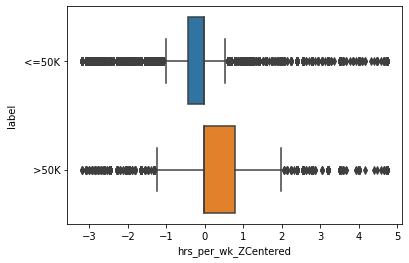

In [230]:
sb.boxplot( x=data_original["hrs_per_wk_ZCentered"], y=data_original["label"] )

The > 50k group here shows a higher average number of hours worked per week than the <= 50k group. Both distributions have pretty tight quartiles and have many outliers. 

Text(0.5, 0.98, 'Interaction of workclass ~ label')

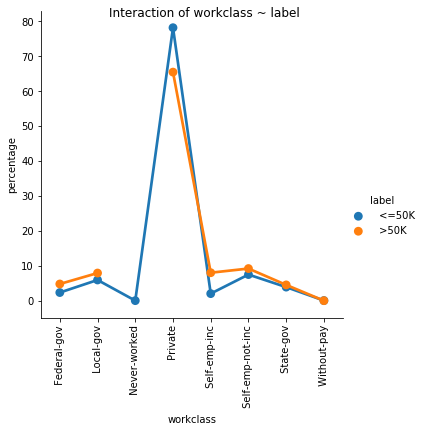

In [231]:
hue_lab = 'label'
x_lab = 'workclass'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

There's some interaction here. The percentage of individuals making > 50k is higher in all factor levels except for 'Private' and 'never-worked'. Could be useful. I would have expected private workers to have the advantage here. I don't know how this works . . .

Text(0.5, 0.98, 'Interaction of education ~ label')

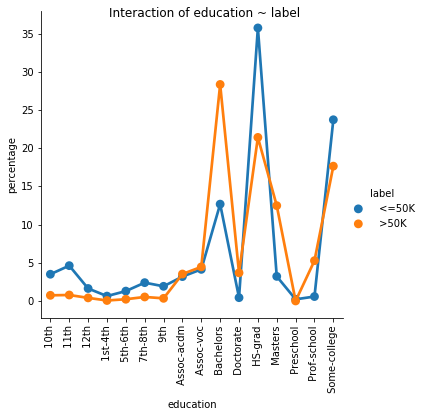

In [232]:
hue_lab = 'label'
x_lab = 'education'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Again, similar to the interaction between education ~ cap-gains50k, we see advanced degrees such as 'Prof-school', 'Bachelors', 'Masters', & 'Doctorate' having the advantage here. Pretty significant difference in the proportions at these levels.

Text(0.5, 0.98, 'Interaction of marital-status ~ label')

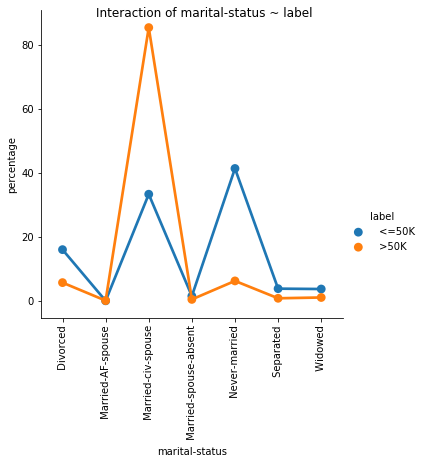

In [233]:
hue_lab = 'label'
x_lab = 'marital-status'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Again, we see greater financial succes with married individuals. Joint income is powerful. We also see a higher frequency of <= 50k individuals under the 'Never-married' factor level.

Text(0.5, 0.98, 'Interaction of occupation ~ label')

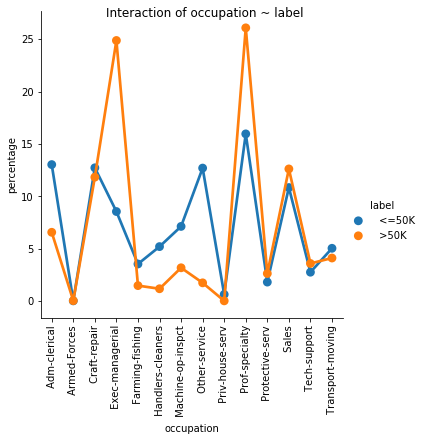

In [234]:
hue_lab = 'label'
x_lab = 'occupation'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Occupation levels provide a lot of variation in frequency regarding our label. The two best off occupation levels are 'Prof-specialty' and 'Exec-managerial'. Likely due to higher than average pay.

Text(0.5, 0.98, 'Interaction of relationship ~ label')

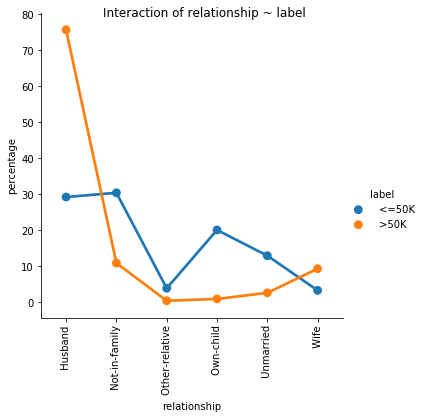

In [235]:
hue_lab = 'label'
x_lab = 'relationship'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

Individuals that're Husband or wives, again, appear better off. Liekly another redundant effec that we've seen under the 'marital-status ~ label' interaction.

Text(0.5, 0.98, 'Interaction of race ~ label')

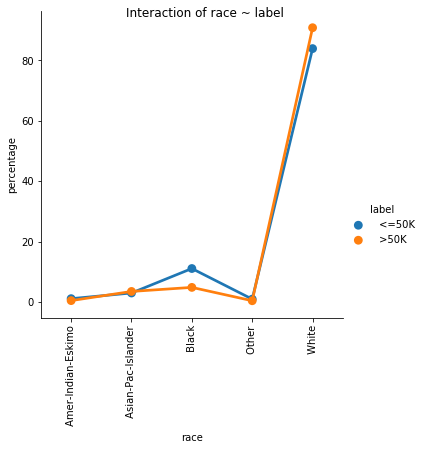

In [236]:
hue_lab = 'label'
x_lab = 'race'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This interaction doesn't appear to be especially interesting for all races except black individuals, whom unfortunatly have a higher frequency of making less than 50k. The remaining racial groups are all very similar.

Text(0.5, 0.98, 'Interaction of sex ~ label')

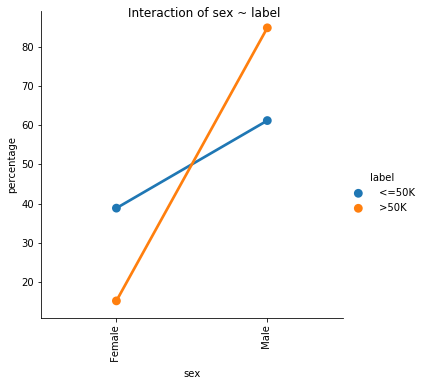

In [237]:
hue_lab = 'label'
x_lab = 'sex'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

This graph is almost identical to the relationship 'sex ~ cap-gains50k'. We, again, see men being more likely to make more than 50k than women. Likely, attributable to the effect of child rearing on average.

Text(0.5, 0.98, 'Interaction of label ~ cap-gains50k')

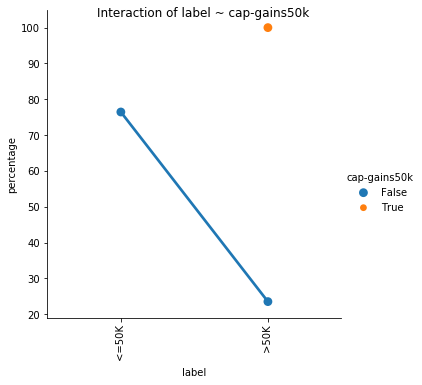

In [238]:
hue_lab = 'cap-gains50k'
x_lab = 'label'

hue_group = data_original.groupby([hue_lab], sort=False)
counts = hue_group[x_lab].value_counts(normalize=True, sort=False)
data = [
    {hue_lab: hue, x_lab: x, 'percentage': percentage*100} for 
    (hue, x), percentage in dict(counts).items()
]
df = pd.DataFrame(data)
p = sb.catplot(x=x_lab, y='percentage', hue=hue_lab, kind="point", data=df);
p.set_xticklabels(rotation=90)
p.fig.suptitle(f'Interaction of {x_lab} ~ {hue_lab}')

All individuals making capital gains greater than 50k end the year with the label >50k. (This is why I made this feature) Roughly 20% of individuals making less than 50k in capital gains still make >50k, so this won't be the only feature we need to predict the label.

#######################################################################################################################################################

# ***Summary of findings after EDA***

In [239]:
# Finally, dropping any duplicate rows
first_len = len(data_original)
data_original.drop_duplicates()
print(f'Dropped {first_len - len(data_original)} records.')



# Final data set
data_original.head()

Dropped 0 records.


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,log_fnl_wgt_ZCentered,education_num_ZCentered,cap-gains50k,log_cap_gain,cap_gain_ZCentered,log_cap_gain_ZCentered,log_cap_loss,cap_loss_ZCentered,log_cap_loss_ZCentered,hrs_per_wk_ZCentered
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,-1.148845,1.136512,False,7.684784,0.146932,2.844559,0.0,-0.217127,-0.221264,-0.034087
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,-1.034554,1.136512,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-2.213032
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0.473106,-0.419335,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-0.034087
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,0.607470,-1.197259,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-0.034087
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,1.187445,1.136512,False,0.000000,-0.144804,-0.297918,0.0,-0.217127,-0.221264,-0.034087


I've kept all of the features of the original data set in order to preserve the information available when we begin modelling the data.

For each numeric feature I created a new transformed feature using either the log, the z-score, and/or the s-zcore and log. Some models fail (especially those using gradient descent) if some features have much larger numbers than others. The features: 'age', 'fnlwgt', 'cap_gain', and 'cap_loss' were all transformed using the log function before they were scaled by the Z-score.

I created one new feature, 'cap-gain50k' which is a binary categorical feature. Its value is True if the individual made more than 50k in capital gains and False otherwise.

None of the outliers that I've observed appeared erroneous so I've left them as is. 

Missing values within a categorical feature were replaced with the mode value. Missing values within a numeric feature were replaced with the mean value.

In [252]:
print(len(train_original), end = '\t')
print(len(test_original))

test_set = data_original.tail(16281)
data_original = data_original.head(32561)



32561	16281


#######################################################################################################################################################

# ***Defining model evaluation measures***

Our label distributions are pretty unbalanced. So, accuracy alone won't be a good measure of how our model is performing.
I think it'll best best to utilize a cost matrix, accuracy, and our type 1 and 2 error rates.
S.T.:

I believe these measures will be best because we'll be able to emphasize amount of correct classifications, false positives, and false negatives.

Based on the EDA I conducted above, I believe the best model to use for predicting our label will be based on the following variables:

cap-gains50k, sex, relationship, occupation, education, workclass, age, and hrsperwk

These variables have little interaction with eachother but more so with the label than the remaining variables. I'll test a variation of the model for each kind of numeric transformation I created in the pre-processing phase to see which data works best. 

#######################################################################################################################################################

# ***Implementing kNN from scratch + fitting and testing***


In [87]:
"""
Needed for sorting the distance results tied to the class labels of the training set, pulled from geeksforgeeks.org

list1: array, the distances
list2: array, the labels
"""
def sort_list(list1, list2): 
    # connecting the lists by a tuple
    zipped_pairs = zip(list1, list2) 
    # sorting using the values in list1 as keys
    y = sorted(zipped_pairs)
    #creating a collection of the sorted labels
    z = [x for _, x in y] 
    return z 

"""
kNN implemented such that many values of k can be tested with a single distance calulation 
xtrain and xtest must have the same number of columns

xtrain: matrix, the training matrix
xtest: matrix, data to predict
ytrain: vector, training labels
ytest: vector, test labels
k: array, contains numbers of neighbors to look at (default is [1]) can be any length so ling as k[0] >= 1 and elements are in monotonic increasing order
distance: str, distance metric (default is euclidean)
    distance functions can be:  ‘jaccard’, ‘euclidean’

"""
def kNN(xtrain, xtest, ytrain, ytest, k = [1], distance = 'euclidean'):
    # create a collection of length len(k), of collections of length len(test labels) to store our result in
    result_array = [[' >50K' for j in range(ytest.shape[0])] for x in range(len(k))]
    # calculating distances between the training and test set, result is a matrix where row i is all distances of test instance i to each training observation
    dist = sp.cdist(xtest, xtrain, distance)
    # iterate over the length of the test set
    for i in range(ytest.shape[0]):
        # peel off the first layer of ditances
        d_test = dist[i, :]
        # copy the training labels so they can be rearranged
        lab_copy = ytrain
        # sort the training labels based on the distances associated with them
        best_labels = sort_list(d_test, lab_copy)
        # count stores the number of <=50k votes, idx stores the index of the k collection we want to get the value of
        count, idx = 0, 0
        # upper limit of k values
        big_k_idx = len(k) - 1 
        # iterate over all k nearest neighbors and tally votes
        for e in range(k[big_k_idx]):
            if best_labels[e] == ' <=50K':
                count += 1
            # for each value of k, when it is reached, set result element based on majority vote
            if e + 1 == k[idx] and count > (k[idx] / 2):
                result_array[idx][i] = ' <=50K'
                idx += 1
            elif e + 1 == k[idx]:
                idx += 1
    return result_array

In [74]:
"""
Plotting cost scores for kNN-from scratch model for many given k values

data: pd dataframe, features and label
cat_columns: array, names of categorical columns to create dummy encodings for
random_seed_adder: int, value to be used in calculating random seed of train-test split
distance: str, metric to be used in distance calculation

"""
def test_scratch_knn(data, cat_columns, random_seed_adder, distance = 'euclidean'):
    # define number of expiriments to perform and the values of k to test
    runs, k_vals = 5, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
    # start timer
    start = time.perf_counter()
    # initialize matrix to hold confusion matrix for each value of k to be tested
    result_avgs = [[0, 0, 0, 0] for k in k_vals ]

    # repeat expiriment {runs} times
    for i in range(runs):
        print(f'RUN {i} STARTING . . .', end='\t')
        data_knn_full = data
        # create dummy encodings of categorical features
        data_knn_full = pd.get_dummies(data_knn_full, columns=cat_columns)
        # split into train and test set
        data_split = sk.model_selection.train_test_split(data_knn_full, test_size = 0.2, random_state = i + random_seed_adder)
        train, test = data_split[0], data_split[1]

        # seperate features from labels
        xtrain = train.drop(columns=['label'])
        xtest = test.drop(columns=['label'])
        ytrain = train['label']
        ytest = test['label']

        # create simple list of test labels
        y = ytest.values.tolist()
        
        # predict result matrix
        result = kNN(xtrain, xtest, ytrain, ytest, k_vals, distance)
        
        # iterate over each row in the matrix (results for fixed k value)
        for l in range(len(result)):
            count_true_pos, count_false_pos, count_true_neg, count_false_neg = 0, 0, 0, 0
            # iterate over the results for fixed k value and increment counts for each metric of the confusion matrix
            for j in range(len(result[l])):
                if y[j] == ' >50K':
                    if result[l][j] == y[j]:
                        count_true_pos += 1
                    else:
                        count_false_neg += 1
                else:
                    if result[l][j] == y[j]:
                        count_true_neg += 1
                    else:
                        count_false_pos += 1
            # average the counts based on the number of expiriments to run
            result_avgs[l][0] += count_true_pos / runs
            result_avgs[l][1] += count_false_pos / runs
            result_avgs[l][2] += count_true_neg / runs
            result_avgs[l][3] += count_false_neg / runs
        print(f'RUN {i} FINISHED.')
        
    # output time elapsed
    end = time.perf_counter()
    print(f'finished execution in {(end - start) / 60} min')

    # plot cost curve for all k values
    y_cost = [arr[0] * -5 + arr[1] * 5 for arr in result_avgs]
    plt.plot(k_vals, y_cost)
    plt.title('avg cost vs k hyperparameter')
    plt.xlabel('K hyperparameter')
    plt.ylabel('avg cost')
    plt.show()

In [90]:
"""
Compute and print the cost matrix for a single k value. Utilizes kNN from scratch

data: pd dataframe, features and label
cat_columns: array, names of categorical columns to create dummy encodings for
random_seed_adder: int, value to be used in calculating random seed of train-test split
k: int, the number of neighbors to tally a vote with
distance: str, metric to be used in distance calculation

"""
def get_cost_scratch_knn(data, cat_columns, random_seed_adder, k = 1, distance='euclidean'):
    # define number of expiriments to perform and initialize confusion matrix
    runs= 5
    result_avgs = [0, 0, 0, 0]

    # repeat expiriment {runs} times
    for a in range(runs):
        print(f'RUN {a} STARTING . . .', end='\t')
        data_knn_full = data
        # create dummy encodings of categorical features
        data_knn_full = pd.get_dummies(data_knn_full, columns=cat_columns)
        # split into train and test set
        data_split = sk.model_selection.train_test_split(data_knn_full, test_size = 0.1, random_state = a + random_seed_adder)
        train, test = data_split[0], data_split[1]

        # seperate features from labels
        xtrain = train.drop(columns=['label'])
        xtest = test.drop(columns=['label'])
        ytrain = train['label']
        ytest = test['label']
        
        #predict result matrix
        result = kNN(xtrain, xtest, ytrain, ytest, [k], distance)
        
        # create simple list of test labels
        y = ytest.values.tolist()

        count_true_pos, count_false_pos, count_true_neg, count_false_neg = 0, 0, 0, 0
        # iterate over the results for fixed k value and increment counts for each metric of the confusion matrix
        for j in range(len(result[0])):
            if y[j] == ' >50K':
                if result[0][j] == y[j]:
                    count_true_pos += 1
                else:
                    count_false_neg += 1
            else:
                if result[0][j] == y[j]:
                    count_true_neg += 1
                else:
                    count_false_pos += 1
        # average the counts based on the number of expiriments to run
        result_avgs[0] += count_true_pos / runs
        result_avgs[1] += count_false_pos / runs
        result_avgs[2] += count_true_neg / runs
        result_avgs[3] += count_false_neg / runs
        print(f'RUN {a} FINISHED.')

    # print the cost matrix
    print()     
    print(f'COST MATRIX FOR K = {k}: ')
    print(f'*********************************')
    print(f'| TP = {round(result_avgs[0] * -5, 2)} \t| FP = +{round(result_avgs[1] * 5, 2)} \t|')
    print(f'*********************************')
    print(f'COST ON SAMPLE: {result_avgs[0] * -5 + result_avgs[1] * 5}')
    print(f'ACCURACY: {(result_avgs[0] + result_avgs[2])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'ALPHA: {(result_avgs[1])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'BETA: {(result_avgs[3])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}')
    print()

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.
finished execution in 26.730249928333343 min


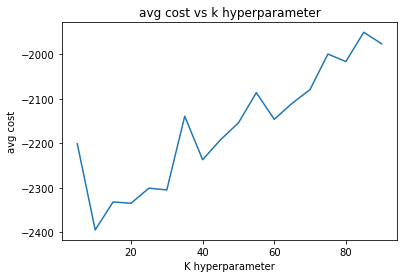

In [107]:
#Testing model with raw data
test_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 875637)

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.
finished execution in 27.083161585000003 min


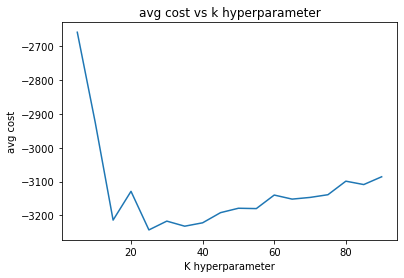

In [108]:
#Testing model with log transformed data
test_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 54968)

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.
finished execution in 27.06364774333333 min


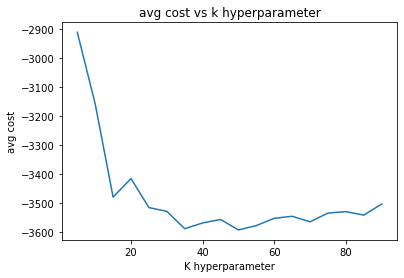

In [109]:
#Testing model with z-score centered data
test_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 524685)

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.
finished execution in 27.88090130666666 min


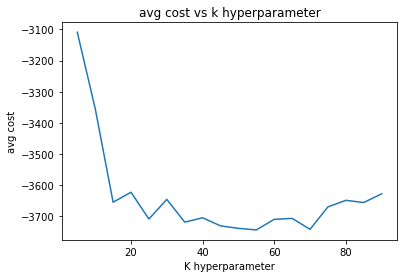

In [110]:
#Testing model with log and z-score centered data
test_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 674896)

In [91]:
#Testing model with raw data, k = 10
get_cost_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                                     ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 545, 10)

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.

COST MATRIX FOR K = 10: 
*********************************
| TP = -2449.0 	| FP = +1238.0 	|
*********************************
COST ON SAMPLE: -1211.0
ACCURACY: 0.8114227226202662	ALPHA: 0.050685772773797336	BETA: 0.13789150460593652



In [92]:
#Testing model with log transformed data, k = 25
get_cost_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 6843576, 25)

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.

COST MATRIX FOR K = 25: 
*********************************
| TP = -3133.0 	| FP = +1483.0 	|
*********************************
COST ON SAMPLE: -1650.0000000000002
ACCURACY: 0.828085977482088	ALPHA: 0.060716479017400196	BETA: 0.11119754350051175



In [93]:
#Testing model with z-score centered data, k = 50
get_cost_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 457668, 50)

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.

COST MATRIX FOR K = 50: 
*********************************
| TP = -3307.0 	| FP = +1500.0 	|
*********************************
COST ON SAMPLE: -1806.9999999999998
ACCURACY: 0.8381985670419652	ALPHA: 0.06141248720573184	BETA: 0.10038894575230296



In [94]:
#Testing model with log and z-score centered data, k = 55
get_cost_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 3235, 55)

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.

COST MATRIX FOR K = 55: 
*********************************
| TP = -3285.0 	| FP = +1476.0 	|
*********************************
COST ON SAMPLE: -1809.0
ACCURACY: 0.8353735926305016	ALPHA: 0.060429887410440135	BETA: 0.10419651995905835



In [79]:
# Note: I tried to parallelize the kNN hyperparam tuning myself to increase speed but ran into os compatibility problems while creating new processes within jupyter lab and gave up
# see following for more detail: https://forums.fast.ai/t/l14-problem-with-futures-and-processpoolexecutor/4548/5
# https://stackoverflow.com/questions/43836876/processpoolexecutor-works-on-ubuntu-but-fails-with-brokenprocesspool-when-r
# I tried running my parallel code in a module seperate from the notebook and that failed too 

## Comments on model performance with Euclidiean distance metric:

Best performance for z-score of log transformed data: 

## Now testing jaccard distance metric

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.
finished execution in 22.490831489999984 min


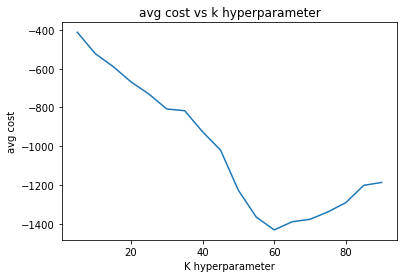

In [114]:
#Testing model with only categorical data
test_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 63854, 'jaccard')

In [95]:
#Testing model with only categorical data, k = 60, distance = 'jaccard'
get_cost_scratch_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass']], 
                                     ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 5445, 60, 'jaccard')

RUN 0 STARTING . . .	RUN 0 FINISHED.
RUN 1 STARTING . . .	RUN 1 FINISHED.
RUN 2 STARTING . . .	RUN 2 FINISHED.
RUN 3 STARTING . . .	RUN 3 FINISHED.
RUN 4 STARTING . . .	RUN 4 FINISHED.

COST MATRIX FOR K = 60: 
*********************************
| TP = -945.0 	| FP = +320.0 	|
*********************************
COST ON SAMPLE: -625.0
ACCURACY: 0.7899692937563971	ALPHA: 0.013101330603889457	BETA: 0.1969293756397134



# Fitting and testing sklearn ~ knn


In [101]:
"""
Utilizing GridSearchCV's parallel processing to speed up the process of finding the optimal k value.
Maximum number of available processors will be used.

data: pd dataframe, the features and labels
cat_columns: array, names of categorical columns to create dummy encodings for
distance: str, metric to be used in distance calculation

"""
def fit_sklearn_knn_hyperparams(data, cat_columns, distance = 'euclidean'):
    
    """
    Definition of custom scoring function that utilizes our cost function.
    
    y: array, actual test labels
    y_pred: array, predicted labels
    """
    def cost_function(y, y_pred):
        cost = 0
        for x1, x2 in zip(y, y_pred):
            # decrease cost by 5 for every true positive
            if x2 == 1 and x1 == x2:
                cost -= 5
            elif x2 == 1 and x1 != x2:
                # increase cost by 5 for every false positive
                cost += 5
        return cost
    
    # initialize scorer function, compatible with GridSearchCV
    my_scorer = make_scorer(cost_function, greater_is_better=False)

    data_knn_full = data
    # create dummy encodings of categorical features
    data_knn_full = pd.get_dummies(data_knn_full, columns=cat_columns)

    # define the values of k to test
    k = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
    grid_param = {'n_neighbors': k}

    # initialize model with given distance metric
    model = KNeighborsClassifier(metric = distance)
    # initialize grid search with custom scoring function, using default number of folds (5)
    KNN_random = GridSearchCV(estimator = model, 
                                 param_grid = grid_param,
                                 scoring = my_scorer,
                                 verbose=2,
                                 n_jobs = -1)
    # begin tuning
    KNN_random.fit(data_knn_full.drop(columns=['label']), data_knn_full['label'].replace([" <=50K", " >50K"], [0, 1]))
    # print results
    print(KNN_random.best_params_)
    print(f'cost: -{KNN_random.best_score_}')

In [102]:
"""
Compute and print the cost matrix for a single k value. Utilizes sklearn kNN.

data: pd dataframe, features and label
cat_columns: array, names of categorical columns to create dummy encodings for
random_seed_adder: int, value to be used in calculating random seed of train-test split
distance: str, metric to be used in distance calculation
k: int, the number of neighbors to tally a vote with

"""
def test_sklearn_knn(data, cat_columns, random_seed_adder, distance='euclidean', k = 1):
    # define number of expiriments to perform and initialize confusion matrix
    runs= 5
    result_avgs = [0, 0, 0, 0]

    # repeat expiriment {runs} times
    for a in range(runs):
        data_knn_full = data
        # create dummy encodings of categorical features
        data_knn_full = pd.get_dummies(data_knn_full, columns=cat_columns)
        # split into train and test set
        data_split = sk.model_selection.train_test_split(data_knn_full, test_size = 0.1, random_state = a + random_seed_adder)
        train, test = data_split[0], data_split[1]

        # seperate features from labels, replace labels with 0s and 1s
        xtrain = train.drop(columns=['label'])
        xtest = test.drop(columns=['label'])
        ytrain = train['label'].replace([" <=50K", " >50K"], [0, 1])
        ytest = test['label'].replace([" <=50K", " >50K"], [0, 1])

        # predict result matrix
        knn = KNeighborsClassifier(n_neighbors = k, metric = distance)
        knn.fit(xtrain, ytrain)
        result = knn.predict(xtest)

        # create simple list of test labels
        y = ytest.values.tolist()

        # iterate over the results for fixed k value and increment counts for each metric of the confusion matrix
        count_true_pos, count_false_pos, count_true_neg, count_false_neg = 0, 0, 0, 0
        for j in range(len(result)):
            if y[j] == 1:
                if result[j] == y[j]:
                    count_true_pos += 1
                else:
                    count_false_neg += 1
            else:
                if result[j] == y[j]:
                    count_true_neg += 1
                else:
                    count_false_pos += 1
        # average the counts based on the number of expiriments to run
        result_avgs[0] += count_true_pos / runs
        result_avgs[1] += count_false_pos / runs
        result_avgs[2] += count_true_neg / runs
        result_avgs[3] += count_false_neg / runs

    # print cost matrix
    print()     
    print(f'COST MATRIX FOR K = {k}: ')
    print(f'*********************************')
    print(f'| TP = {round(result_avgs[0] * -5, 2)} \t| FP = +{round(result_avgs[1] * 5, 2)} \t|')
    print(f'*********************************')
    print(f'COST ON SAMPLE: {result_avgs[0] * -5 + result_avgs[1] * 5}')
    print(f'ACCURACY: {(result_avgs[0] + result_avgs[2])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'ALPHA: {(result_avgs[1])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'BETA: {(result_avgs[3])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}')
    print()

In [103]:
#Fitting model with raw data
fit_sklearn_knn_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   54.5s finished


{'n_neighbors': 20}
cost: -2496.0


In [104]:
#Fitting model with log transformed data
fit_sklearn_knn_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


{'n_neighbors': 35}
cost: -3299.0


In [105]:
#Fitting model with z-score centered data
fit_sklearn_knn_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.8min finished


{'n_neighbors': 65}
cost: -3636.0


In [106]:
#Fitting model with log and z-score centered data
fit_sklearn_knn_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.7min finished


{'n_neighbors': 50}
cost: -3639.0


In [112]:
#Testing model with raw data, k = 20
test_sklearn_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 8546, distance = 'euclidean', k = 20)


COST MATRIX FOR K = 20: 
*********************************
| TP = -2661.0 	| FP = +1537.0 	|
*********************************
COST ON SAMPLE: -1123.9999999999998
ACCURACY: 0.8127737973387922	ALPHA: 0.06292732855680656	BETA: 0.12429887410440124



In [113]:
#Testing model with log transformed data, k = 35
test_sklearn_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 324, distance = 'euclidean', k = 35)


COST MATRIX FOR K = 35: 
*********************************
| TP = -3218.0 	| FP = +1515.0 	|
*********************************
COST ON SAMPLE: -1702.9999999999995
ACCURACY: 0.8322620266120778	ALPHA: 0.06202661207778915	BETA: 0.10571136131013306



In [114]:
#Testing model with z-score centered data, k = 65
test_sklearn_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 496874, distance = 'euclidean', k = 65)


COST MATRIX FOR K = 65: 
*********************************
| TP = -3354.0 	| FP = +1521.0 	|
*********************************
COST ON SAMPLE: -1833.0
ACCURACY: 0.836028659160696	ALPHA: 0.062272262026612075	BETA: 0.1016990788126919



In [115]:
#Testing model with log and z-score centered data, k = 50
test_sklearn_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 964678, distance = 'euclidean', k = 50)


COST MATRIX FOR K = 50: 
*********************************
| TP = -3313.0 	| FP = +1493.0 	|
*********************************
COST ON SAMPLE: -1820.0000000000002
ACCURACY: 0.8409825997952917	ALPHA: 0.06112589559877174	BETA: 0.09789150460593654



## Best kNN Euclidiean distance metric model:

Best performance is for z-score transformed data:

## Now testing jaccard distance metric

In [109]:
#Fitting model with just categorical features
fit_sklearn_knn_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 'jaccard')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 13.3min finished


{'n_neighbors': 55}
cost: -3373.0


In [117]:
#Testing model with just categorical features, k = 55, distance = 'jaccard'
test_sklearn_knn(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass']], 
                 ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 872346, 'jaccard', k = 55)


COST MATRIX FOR K = 55: 
*********************************
| TP = -2970.0 	| FP = +1397.0 	|
*********************************
COST ON SAMPLE: -1573.0
ACCURACY: 0.8302968270214943	ALPHA: 0.05719549641760491	BETA: 0.11250767656090072



## Comparison of sklearn knn vs scratch knn

My implementation of knn is actually slightly faster than sklearn when testing multiple K values. Grid search tuning of sklearn-kNN takes between 1 and 4.5 mins utilizing 12 processor cores. My implmenation, testing the same number of k values and using the same number of cross validation folds takes on average 27 mins. 27 / 12 = 2.25. So, theoretically I'm in the same range if I could parallelized accordingly. 

I wrote my implementation to test multiple values of k over the same distance matrix. sklearn requires reinitialization and recalculation of distance for each k value. (Especially apparent when calculating jaccard distance.)

However, avg. sklearn achieved slightly higher accuracy and beteer cost on each dataset for the various values of K. sklearn beat my model by about 30 cost when comparing the best of the models, which I can probably attribute somewhat to randomness.

# Fitting and testing sklearn ~ Random Forest
I'm choosing to test a random forest here because of hte lack of assumptions for the model and it's general robustness to the imbalanced class problem. I think it will perform better than kNN.

In [81]:
"""
Utilizing RandomizedSearchCV's parallel processing to speed up the process of finding the optimal values of n_estimators, min_samples_split, and min_samples_leaf.
Fitting a Random Forest.
Maximum number of available processors will be used.

data: pd dataframe, the features and labels
cat_columns: array, names of categorical columns to create dummy encodings for
random_seed_adder: int, value to be used in calculating random seed of train-test split

"""
def fit_sklearn_rf_hyperparams(data, cat_columns, random_seed_adder):
    
    """
    Definition of custom scoring function that utilizes our cost function.
    
    y: array, actual test labels
    y_pred: array, predicted labels
    """
    def cost_function(y, y_pred):
        cost = 0
        for x1, x2 in zip(y, y_pred):
            # decrease cost by 5 for every true positive
            if x2 == 1 and x1 == x2:
                cost -= 5
            elif x2 == 1 and x1 != x2:
                # increase cost by 5 for every false positive
                cost += 5
        return cost
    
    # initialize scorer function, compatible with RandomizedSearchCV
    my_scorer = make_scorer(cost_function, greater_is_better=False)

    data_rf_full = data
    # create dummy encodings of categorical features
    data_rf_full = pd.get_dummies(data_rf_full, columns=cat_columns)

    # define the values of n_estimators, min_samples_split, min_samples_leaf to test
    # n_estimators effects the bias of the model
    # min_samples_split and min_samples_leaf mainly effect model variance
    n_estimators = [100, 200, 500]
    min_samples_split = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
    min_samples_leaf = [1, 2, 5, 10, 15, 20, 25, 30]
    grid_param = {'n_estimators': n_estimators,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf}
    
    # initialize model
    model = rf(random_state=1)
    # initialize randomized search with custom scoring function, using default number of folds (5)
    RFC_random = RandomizedSearchCV(estimator = model, 
                                 param_distributions = grid_param,
                                 n_iter = 100,
                                 scoring = my_scorer,
                                 verbose=2,
                                 random_state = random_seed_adder,
                                 n_jobs = -1)
    # begin tuning
    RFC_random.fit(data_rf_full.drop(columns=['label']), data_rf_full['label'].replace([" <=50K", " >50K"], [0, 1]))
    # print results
    print(RFC_random.best_params_)
    print(f'cost: -{RFC_random.best_score_}')

In [85]:
"""
Compute and print the cost matrix for a single hyperparameter setting. Utilizes sklearn Random Forest.

data: pd dataframe, features and label
cat_columns: array, names of categorical columns to create dummy encodings for
random_seed_adder: int, value to be used in calculating random seed of train-test split
n_trees: int, number of trees to generate
m_min: int, min number of samples required to split a node
m_leave: int, min number of samples required to be at each leaf 

"""
def test_sklearn_rf(data, cat_columns, random_seed_adder, n_trees, m_min, m_leave):
    # define number of expiriments to perform and initialize confusion matrix
    runs = 5
    result_avgs = [0, 0, 0, 0]

    # repeat expiriment {runs} times
    for a in range(runs):
        data_knn_full = data
        # create dummy encodings of categorical features
        data_knn_full = pd.get_dummies(data_knn_full, columns=cat_columns)
        # split into train and test set
        data_split = sk.model_selection.train_test_split(data_knn_full, test_size = 0.1, random_state = a + random_seed_adder)
        train, test = data_split[0], data_split[1]

        # seperate features from labels, replace labels with 0s and 1s
        xtrain = train.drop(columns=['label'])
        xtest = test.drop(columns=['label'])
        ytrain = train['label'].replace([" <=50K", " >50K"], [0, 1])
        ytest = test['label'].replace([" <=50K", " >50K"], [0, 1])

        # initialize model and predict result matrix
        rf_model = rf(n_estimators = n_trees, min_samples_split = m_min, min_samples_leaf = m_leave)
        rf_model.fit(xtrain, ytrain)
        result = rf_model.predict(xtest)

        # create simple list of test labels
        y = ytest.values.tolist()

        count_true_pos, count_false_pos, count_true_neg, count_false_neg = 0, 0, 0, 0
        # iterate over the results and increment counts for each metric of the confusion matrix
        for j in range(len(result)):
            if y[j] == 1:
                if result[j] == y[j]:
                    count_true_pos += 1
                else:
                    count_false_neg += 1
            else:
                if result[j] == y[j]:
                    count_true_neg += 1
                else:
                    count_false_pos += 1
        # average the counts based on the number of expiriments to run
        result_avgs[0] += count_true_pos / runs
        result_avgs[1] += count_false_pos / runs
        result_avgs[2] += count_true_neg / runs
        result_avgs[3] += count_false_neg / runs

    # print cost matrix
    print()     
    print(f'COST MATRIX n_estimators = {n_trees}, min_samples_split = {m_min}, min_samples_leaf = {m_leave}: ')
    print(f'*********************************')
    print(f'| TP = {round(result_avgs[0] * -5, 2)} \t| FP = +{round(result_avgs[1] * 5, 2)} \t|')
    print(f'*********************************')
    print(f'COST ON SAMPLE: {result_avgs[0] * -5 + result_avgs[1] * 5}')
    print(f'ACCURACY: {(result_avgs[0] + result_avgs[2])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'ALPHA: {(result_avgs[1])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'BETA: {(result_avgs[3])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}')
    print()

In [83]:
#Fitting model with raw data
fit_sklearn_rf_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 654)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.1min finished


{'n_estimators': 100, 'min_samples_split': 45, 'min_samples_leaf': 1}
cost: -3957.0


In [348]:
#Fitting model with log transformed data
fit_sklearn_rf_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 96846)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.0min finished


{'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 1}
cost: -3960.0


In [349]:
#Fitting model with z-score centered data
fit_sklearn_rf_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 496874)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.6min finished


{'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 1}
cost: -3964.0


In [350]:
#Fitting model with log and z-score centered data
fit_sklearn_rf_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 564)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.1min finished


{'n_estimators': 200, 'min_samples_split': 55, 'min_samples_leaf': 1}
cost: -3976.0


In [351]:
#Testing model with raw data, n_estimators = 100, min_samples_split = 45, min_samples_leaf = 1
test_sklearn_rf(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 564684, 100, 45, 1)


COST MATRIX n_estimators = 100, min_samples_split = 45, min_samples_leaf = 1: 
*********************************
| TP = -3357.0 	| FP = +1369.0 	|
*********************************
| FN = +0.0 	| TN = 0.0 	|
*********************************
COST ON SAMPLE: -1988.0000000000005
ACCURACY: 0.8451586489252816	ALPHA: 0.056049129989764586	BETA: 0.09879222108495393



In [352]:
#Testing model with log transformed data, n_estimators = 200, min_samples_split = 50, min_samples_leaf = 1
test_sklearn_rf(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 8544, 200, 50, 1)


COST MATRIX n_estimators = 200, min_samples_split = 50, min_samples_leaf = 1: 
*********************************
| TP = -3198.0 	| FP = +1352.0 	|
*********************************
| FN = +0.0 	| TN = 0.0 	|
*********************************
COST ON SAMPLE: -1845.9999999999998
ACCURACY: 0.8404094165813717	ALPHA: 0.05535312180143297	BETA: 0.10423746161719549



In [353]:
#Testing model with z-score centered data, n_estimators = 200, min_samples_split = 50, min_samples_leaf = 1
test_sklearn_rf(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 4966874, 200, 50, 1)


COST MATRIX n_estimators = 200, min_samples_split = 50, min_samples_leaf = 1: 
*********************************
| TP = -3320.0 	| FP = +1311.0 	|
*********************************
| FN = +0.0 	| TN = 0.0 	|
*********************************
COST ON SAMPLE: -2009.0
ACCURACY: 0.8412282497441146	ALPHA: 0.05367451381780962	BETA: 0.10509723643807574



In [354]:
#Testing model with log and z-score centered data, n_estimators = 200, min_samples_split = 55, min_samples_leaf = 1
test_sklearn_rf(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 541658, 200, 55, 1)


COST MATRIX n_estimators = 200, min_samples_split = 55, min_samples_leaf = 1: 
*********************************
| TP = -3259.0 	| FP = +1343.0 	|
*********************************
| FN = +0.0 	| TN = 0.0 	|
*********************************
COST ON SAMPLE: -1916.0
ACCURACY: 0.8387717502558855	ALPHA: 0.054984646878198574	BETA: 0.10624360286591607



## Comments on Random Forest model performance :

Best performance is for z-score transformed data: 

# Fitting and testing sklearn ~ Gradient Boosting Classifier
I chose to test a Gradient Boosting Classifier because they're generally even better than random forests for unbalanced class problems. 

In [120]:
"""
Utilizing RandomizedSearchCV's parallel processing to speed up the process of finding the optimal values of n_estimators, min_samples_split, and min_samples_leaf.
Fitting a Gradient Boosting Classifier.
Maximum number of available processors will be used.

data: pd dataframe, the features and labels
cat_columns: array, names of categorical columns to create dummy encodings for
random_seed_adder: int, value to be used in calculating random seed of train-test split

"""
def fit_sklearn_GB_hyperparams(data, cat_columns, random_seed_adder):
    
    """
    Definition of custom scoring function that utilizes our cost function.
    
    y: array, actual test labels
    y_pred: array, predicted labels
    """
    def cost_function(y, y_pred):
        cost = 0
        for x1, x2 in zip(y, y_pred):
            # decrease cost by 5 for every true positive
            if x2 == 1 and x1 == x2:
                cost -= 5
            elif x2 == 1 and x1 != x2:
                # increase cost by 5 for every false positive
                cost += 5
        return cost
    
    # initialize scorer function, compatible with RandomizedSearchCV
    my_scorer = make_scorer(cost_function, greater_is_better=False)

    # define the values of n_estimators, learning_rate, min_samples_split, min_samples_leaf to test
    # n_estimators effects the bias of the model
    # min_samples_split and min_samples_leaf mainly effect model variance
    n_estimators = [100, 200, 500, 700, 900]
    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
    min_samples_split = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
    min_samples_leaf = [1, 2, 5, 10, 15, 20, 25, 30]
    grid_param = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf}
    
    data_gb_full = data
    # create dummy encodings of categorical features
    data_gb_full = pd.get_dummies(data_gb_full, columns=cat_columns)

    # initialize model
    model = gb(random_state=1)
    # initialize randomized search with custom scoring function, using default number of folds (5)
    GB_random = RandomizedSearchCV(estimator = model, 
                                 param_distributions = grid_param,
                                 scoring = my_scorer,
                                 verbose=5,
                                 random_state = random_seed_adder,
                                 n_jobs = -1)
    # begin tuning
    GB_random.fit(data_gb_full.drop(columns=['label']), data_gb_full['label'].replace([" <=50K", " >50K"], [0, 1]))
    # print result
    print(GB_random.best_params_)
    print(f'cost: -{GB_random.best_score_}')

In [127]:
"""
Compute and print the cost matrix for a single hyperparameter setting. Utilizes sklearn Gradient Boosting Classifier.

data: pd dataframe, features and label
cat_columns: array, names of categorical columns to create dummy encodings for
random_seed_adder: int, value to be used in calculating random seed of train-test split
n_trees: int, number of trees to generate
lr: float, the learning rate
m_min: int, min number of samples required to split a node
m_leave: int, min number of samples required to be at each leaf 

"""
def test_sklearn_gb(data, cat_columns, random_seed_adder, n_trees, lr, m_min, m_leave):
    # define number of expiriments to perform and initialize confusion matrix
    runs = 5
    result_avgs = [0, 0, 0, 0]

    # repeat expiriment {runs} times
    for a in range(runs):
        data_knn_full = data
        # create dummy encodings of categorical features
        data_knn_full = pd.get_dummies(data_knn_full, columns=cat_columns)
        # split into train and test set
        data_split = sk.model_selection.train_test_split(data_knn_full, test_size = 0.1, random_state = a + random_seed_adder)
        train, test = data_split[0], data_split[1]

        # seperate features from labels, replace labels with 0s and 1s
        xtrain = train.drop(columns=['label'])
        xtest = test.drop(columns=['label'])
        ytrain = train['label'].replace([" <=50K", " >50K"], [0, 1])
        ytest = test['label'].replace([" <=50K", " >50K"], [0, 1])

        # initialize model and predict result matrix
        gb_model = gb(n_estimators = n_trees, learning_rate = lr, min_samples_split = m_min, min_samples_leaf = m_leave)
        gb_model.fit(xtrain, ytrain)
        result = gb_model.predict(xtest)

        # create simple list of test labels
        y = ytest.values.tolist()

        
        count_true_pos, count_false_pos, count_true_neg, count_false_neg = 0, 0, 0, 0
        # iterate over the results and increment counts for each metric of the confusion matrix
        for j in range(len(result)):
            if y[j] == 1:
                if result[j] == y[j]:
                    count_true_pos += 1
                else:
                    count_false_neg += 1
            else:
                if result[j] == y[j]:
                    count_true_neg += 1
                else:
                    count_false_pos += 1
        # average the counts based on the number of expiriments to run
        result_avgs[0] += count_true_pos / runs
        result_avgs[1] += count_false_pos / runs
        result_avgs[2] += count_true_neg / runs
        result_avgs[3] += count_false_neg / runs
    # print cost matrix
    print()     
    print(f'COST MATRIX n_estimators = {n_trees}, learning_rate = {lr}, min_samples_split = {m_min}, min_samples_leaf = {m_leave}: ')
    print(f'*********************************')
    print(f'| TP = {round(result_avgs[0] * -5, 2)} \t| FP = +{round(result_avgs[1] * 5, 2)} \t|')
    print(f'*********************************')
    print(f'COST ON SAMPLE: {result_avgs[0] * -5 + result_avgs[1] * 5}')
    print(f'ACCURACY: {(result_avgs[0] + result_avgs[2])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'ALPHA: {(result_avgs[1])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}', end='\t')
    print(f'BETA: {(result_avgs[3])/(result_avgs[0] + result_avgs[1] + result_avgs[3] + result_avgs[2])}')
    print()

In [122]:
#Fitting model with raw data
fit_sklearn_GB_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 5416)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:  1.8min remaining:   34.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


{'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 20, 'learning_rate': 0.3}
cost: -4069.0


In [123]:
#Fitting model with log transformed data
fit_sklearn_GB_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 6748)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:  1.9min remaining:   36.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


{'n_estimators': 700, 'min_samples_split': 45, 'min_samples_leaf': 20, 'learning_rate': 0.1}
cost: -4077.0


In [124]:
#Fitting model with z-score centered data
fit_sklearn_GB_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 86784)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:  2.2min remaining:   40.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


{'n_estimators': 900, 'min_samples_split': 50, 'min_samples_leaf': 25, 'learning_rate': 0.05}
cost: -4064.0


In [125]:
#Fitting model with log and z-score centered data
fit_sklearn_GB_hyperparams(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 6874384)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  50 | elapsed:  2.4min remaining:   44.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


{'n_estimators': 500, 'min_samples_split': 55, 'min_samples_leaf': 20, 'learning_rate': 0.1}
cost: -4081.0


In [128]:
#Testing model with raw data, n_estimators = 200, learning_rate = 0.3, min_samples_split = 20, min_samples_leaf = 20
test_sklearn_gb(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 5484, 200, 0.3, 20, 20)


COST MATRIX n_estimators = 200, learning_rate = 0.3, min_samples_split = 20, min_samples_leaf = 20: 
*********************************
| TP = -3351.0 	| FP = +1430.0 	|
*********************************
COST ON SAMPLE: -1921.0
ACCURACY: 0.8422927328556805	ALPHA: 0.058546571136131015	BETA: 0.09916069600818833



In [129]:
#Testing model with log transformed data, n_estimators = 700, learning_rate = 0.1, min_samples_split = 45, min_samples_leaf = 20
test_sklearn_gb(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age', 'hrsperwk']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 85236444, 700, 0.1, 45, 20)


COST MATRIX n_estimators = 700, learning_rate = 0.1, min_samples_split = 45, min_samples_leaf = 20: 
*********************************
| TP = -3427.0 	| FP = +1403.0 	|
*********************************
COST ON SAMPLE: -2024.0
ACCURACY: 0.8444626407369498	ALPHA: 0.057441146366427845	BETA: 0.0980962128966223



In [130]:
#Testing model with z-score centered data, n_estimators = 900, learning_rate = 0.05, min_samples_split = 50, min_samples_leaf = 25
test_sklearn_gb(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 2865, 900, 0.05, 50, 25)


COST MATRIX n_estimators = 900, learning_rate = 0.05, min_samples_split = 50, min_samples_leaf = 25: 
*********************************
| TP = -3380.0 	| FP = +1381.0 	|
*********************************
COST ON SAMPLE: -1999.0
ACCURACY: 0.8431934493346981	ALPHA: 0.05654042988741044	BETA: 0.1002661207778915



In [131]:
#Testing model with log and z-score centered data, n_estimators = 500, learning_rate = 0.1, min_samples_split = 55, min_samples_leaf = 20
test_sklearn_gb(data_original[['label', 'cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass', 'log_age_ZCentered', 'hrs_per_wk_ZCentered']], 
                           ['cap-gains50k', 'sex', 'relationship', 'occupation', 'education', 'workclass'], 1745, 500, 0.1, 55, 20)


COST MATRIX n_estimators = 500, learning_rate = 0.1, min_samples_split = 55, min_samples_leaf = 20: 
*********************************
| TP = -3339.0 	| FP = +1365.0 	|
*********************************
COST ON SAMPLE: -1974.0
ACCURACY: 0.8451586489252816	ALPHA: 0.055885363357215966	BETA: 0.09895598771750257



## Comments on GBC performance:

Best performance is for log transformed data:

# ***Ranking of modelling results based on best cost achieved***

## 1. Gradient Boosting Classifier best performance for log transformed data: 
### label ~ cap-gains50k + sex + relationship + occupation + education + workclass + log_age + hrsperwk

## 2. Random Forest best performance for z-score transformed data: 
### label ~ cap-gains50k + sex + relationship + occupation + education + workclass + age_ZCentered + hrs_per_wk_ZCentered

## 3. sklearn KNN (Euclidean) Best performance for z-score transformed data:
### label ~ cap-gains50k + sex + relationship + occupation + education + workclass + age_ZCentered + hrs_per_wk_ZCentered

## 4. KNN from scratch (Euclidean) Best performance for z-score of log transformed data:
### label ~ cap-gains50k + sex + relationship + occupation + education + workclass + log_age_ZCentered + hrs_per_wk_ZCentered

## 5. sklearn KNN (Jaccard) only categorical model features: 
### label ~ cap-gains50k + sex + relationship + occupation + education + workclass

## 6. KNN from scratch (Jaccard):
### label ~ cap-gains50k + sex + relationship + occupation + education + workclass

#######################################################################################################################################################

Things I learned: first time I've used a library that utilizes parallel processing to tune hyperparameters, very nice. First time I've tried to use my systems knowledge to write my own parallelization module that ended up not working because of jupyterlab, very frustrating. I used a GBC for the first time too. I'm not sure if i shouldv'e tuned the learning rate, I read online that increasing n_estimators is essentially the same as decreasing learning rate so maybe not.